# 5 Matrix Factorization Visualizations

This script is dedicated to visualize the output of matrix factorization, so the entire dataset (not the training data) is loaded as input.

In [1]:
# Setup
import utils
import matrix_factorization as mf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
sns.set()
sns.set_style("white")

In [2]:
# Y_train = utils.get_training_data()
# Y_test = utils.get_test_data()
Y = utils.get_data()
movie_id, movie_title, movie_genre, genres = utils.get_movies()
genre_similarity = utils.genre_similarity(movie_genre)

M = 943 # users
N = 1682 # movies
K = 20
reg = 0.1
eta = 0.03

## 1. Simple SGD from Homework

In [3]:
U_simple, V_simple, err_simple = mf.train_model(Y, M, N, K, eta, reg)
# err_test_simple = mf.get_err(U_simple, V_simple, Y_test)
# err_test_simple /= Y_test.shape[0]

Epoch  0: current average training error 0.493
Epoch  1: current average training error 0.433
Epoch  2: current average training error 0.411
Epoch  3: current average training error 0.396
Epoch  4: current average training error 0.380
Epoch  5: current average training error 0.370
Epoch  6: current average training error 0.360
Epoch  7: current average training error 0.353
Epoch  8: current average training error 0.346
Epoch  9: current average training error 0.343
Epoch 10: current average training error 0.339
Epoch 11: current average training error 0.333
Epoch 12: current average training error 0.331
Epoch 13: current average training error 0.325
Epoch 14: current average training error 0.321
Epoch 15: current average training error 0.325


## 2. Incorporating a Bias Term

In [4]:
U_bias, V_bias, biases, err_bias = mf.train_model(Y, M, N, K, eta, reg, include_bias=True)
# err_test_bias = mf.get_err(U_bias, V_bias, Y_test, biases=biases)
# err_test_bias /= Y_test.shape[0]

Epoch  0: current average training error 0.425
Epoch  1: current average training error 0.407
Epoch  2: current average training error 0.396
Epoch  3: current average training error 0.387
Epoch  4: current average training error 0.376
Epoch  5: current average training error 0.365
Epoch  6: current average training error 0.356
Epoch  7: current average training error 0.348
Epoch  8: current average training error 0.340
Epoch  9: current average training error 0.333
Epoch 10: current average training error 0.327
Epoch 11: current average training error 0.321
Epoch 12: current average training error 0.316
Epoch 13: current average training error 0.312
Epoch 14: current average training error 0.306
Epoch 15: current average training error 0.303
Epoch 16: current average training error 0.300
Epoch 17: current average training error 0.297
Epoch 18: current average training error 0.295
Epoch 19: current average training error 0.292
Epoch 20: current average training error 0.289
Epoch 21: cur

## Off-the-shelf solution

In [5]:
import surprise
from surprise import accuracy
from surprise import SVD
from surprise import Reader
from surprise import Dataset

pkf = surprise.model_selection.PredefinedKFold()
reader = Reader(rating_scale=(1, 5))

fulldata = Dataset.load_from_file("data/data.txt",reader)

surprise_SVD = SVD(n_factors = 20, n_epochs = 30, 
                   lr_all=eta, reg_all=reg, biased = True)

dataset = fulldata.build_full_trainset()
# for trainset, testset in pkf.split(fulldata):

    # train and test algorithm.
surprise_SVD.fit(dataset)
# predictions = surprise_SVD.test(testset)

    # Compute and print Root Mean Squared Error
#     surprise_error = accuracy.rmse(predictions, verbose=True)
# surprise_error = mf.get_err(surprise_SVD.pu.T, surprise_SVD.qi.T, Y_test, 
#              biases=[surprise_SVD.bu, surprise_SVD.bi, biases[2]])/Y_test.shape[0]

## Visualization

### Movie projections

In [6]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import row

def get_SVD_movie_projection(V):
    
     # SVD for the latent factor of the movies
    A, _, _ = np.linalg.svd(V)
    
    V_transformed = np.multiply(A[0:1, :].T, V)
    
    return V_transformed

def get_movie_projection_plot(V, title, size=300):
    
    plot = figure(plot_width=size, plot_height=size, title=title)
    plot.circle(V[0, :], V[1, :])
    plot.xaxis.axis_label = "1"
    plot.yaxis.axis_label = "2"
    plot.toolbar_location = None
    
    return plot

V_simple_transformed = get_SVD_movie_projection(V_simple)
V_bias_transformed = get_SVD_movie_projection(V_bias)
V_surprise_transformed = surprise_SVD.pu[:, 0:2].T

simple_SVD_projection_plot = get_movie_projection_plot(V_simple_transformed, "Simple Movie SVD Projection")
bias_SVD_projection_plot = get_movie_projection_plot(V_bias_transformed, "Biased Movie SVD Projection")
off_the_shelf_projection_plot = get_movie_projection_plot(V_surprise_transformed, "Surprise Movie SVD Projection")
output_notebook()
show(row([simple_SVD_projection_plot, bias_SVD_projection_plot, off_the_shelf_projection_plot]))

Loading BokehJS ...

## a) Visualizing 10 Movies

In [7]:
movies_of_interest = [
    "\"Aristocats, The (1970)\"", "\"Fox and the Hound, The (1981)\"", "Major Payne (1994)", "Toy Story (1995)", "Dunston Checks In (1996)",
    "Taxi Driver (1976)", "\"Boot, Das (1981)\"", "Brazil (1985)", "Schindler's List (1993)", "Alien: Resurrection (1997)"
]

movies_of_interest_ids = []

for movie_of_interest in movies_of_interest:
    movie_index = list(movie_title).index(movie_of_interest)#np.where(movie_title == movie_of_interest)[0]
    movies_of_interest_ids.append(movie_index)

from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label

def get_custom_movie_projection_plot(coordinates, movie_titles, title, size=450):
    
    x_range = max(coordinates[0, :]) - min(coordinates[0, :])
    x_min = min(coordinates[0, :]) - x_range * 0.5
    x_max = max(coordinates[0, :]) + x_range * 0.5
    
    plot = figure(plot_width=size, plot_height=size, title=title, x_range=(x_min, x_max))
    plot.circle(coordinates[0, :], coordinates[1, :])
    plot.xaxis.axis_label = "1"
    plot.yaxis.axis_label = "2"
    source = ColumnDataSource(data=dict(dim1=coordinates[0, :],
                                        dim2=coordinates[1, :],
                                        names=movie_titles))

    plot.scatter(x='dim1', y='dim2', size=8, source=source)

    labels = LabelSet(x='dim1', y='dim2', text='names', level='glyph',
                  x_offset=5, y_offset=5, source=source, render_mode='canvas')
    plot.add_layout(labels)
    
    return plot

simple_SVD_custom_movie_plot = get_custom_movie_projection_plot(V_simple_transformed[:, movies_of_interest_ids], movies_of_interest, "Simple Movie SVD Projection", size=800)
show(simple_SVD_custom_movie_plot)

In [8]:
bias_SVD_custom_movie_plot = get_custom_movie_projection_plot(V_bias_transformed[:, movies_of_interest_ids], movies_of_interest, "Biased Movie SVD Projection", size=800)
show(bias_SVD_custom_movie_plot)

## b) Most popular movies

In [9]:
A, S, B = np.linalg.svd(V_simple) # SVD for the latent factor of the movies
V2_simple = A.T[:2, :]@V_simple # Project V to 2D

A, S, B = np.linalg.svd(V_bias) # SVD for the latent factor of the movies
V2_bias = A.T[:2, :]@V_bias # Project V to 2D


In [10]:
counts, ratings, ratings_bayesian = utils.bayesian_rating(Y, thr=4)
rank_counts = np.argsort(-counts) # Indices of counts in descending order
rank_ratings = np.argsort(-ratings) # Indices of ratings in descending order
rank_ratings_bayesian = np.argsort(-ratings_bayesian) # Indices of ratings in descending order
print(ratings[rank_ratings[:5]], counts[rank_ratings[:5]])
print(ratings[rank_ratings_bayesian[:5]], counts[rank_ratings_bayesian[:5]])
print(movie_title[rank_ratings_bayesian[:5]])

[5. 5. 5. 5. 5.] [1 1 2 1 3]
[4.49107143 4.46644295 4.45679012 4.46610169 4.44522968] [112 298 243 118 283]
['"Close Shave, A (1995)"' "Schindler's List (1993)" 'Casablanca (1942)'
 '"Wrong Trousers, The (1993)"' '"Shawshank Redemption, The (1994)"']


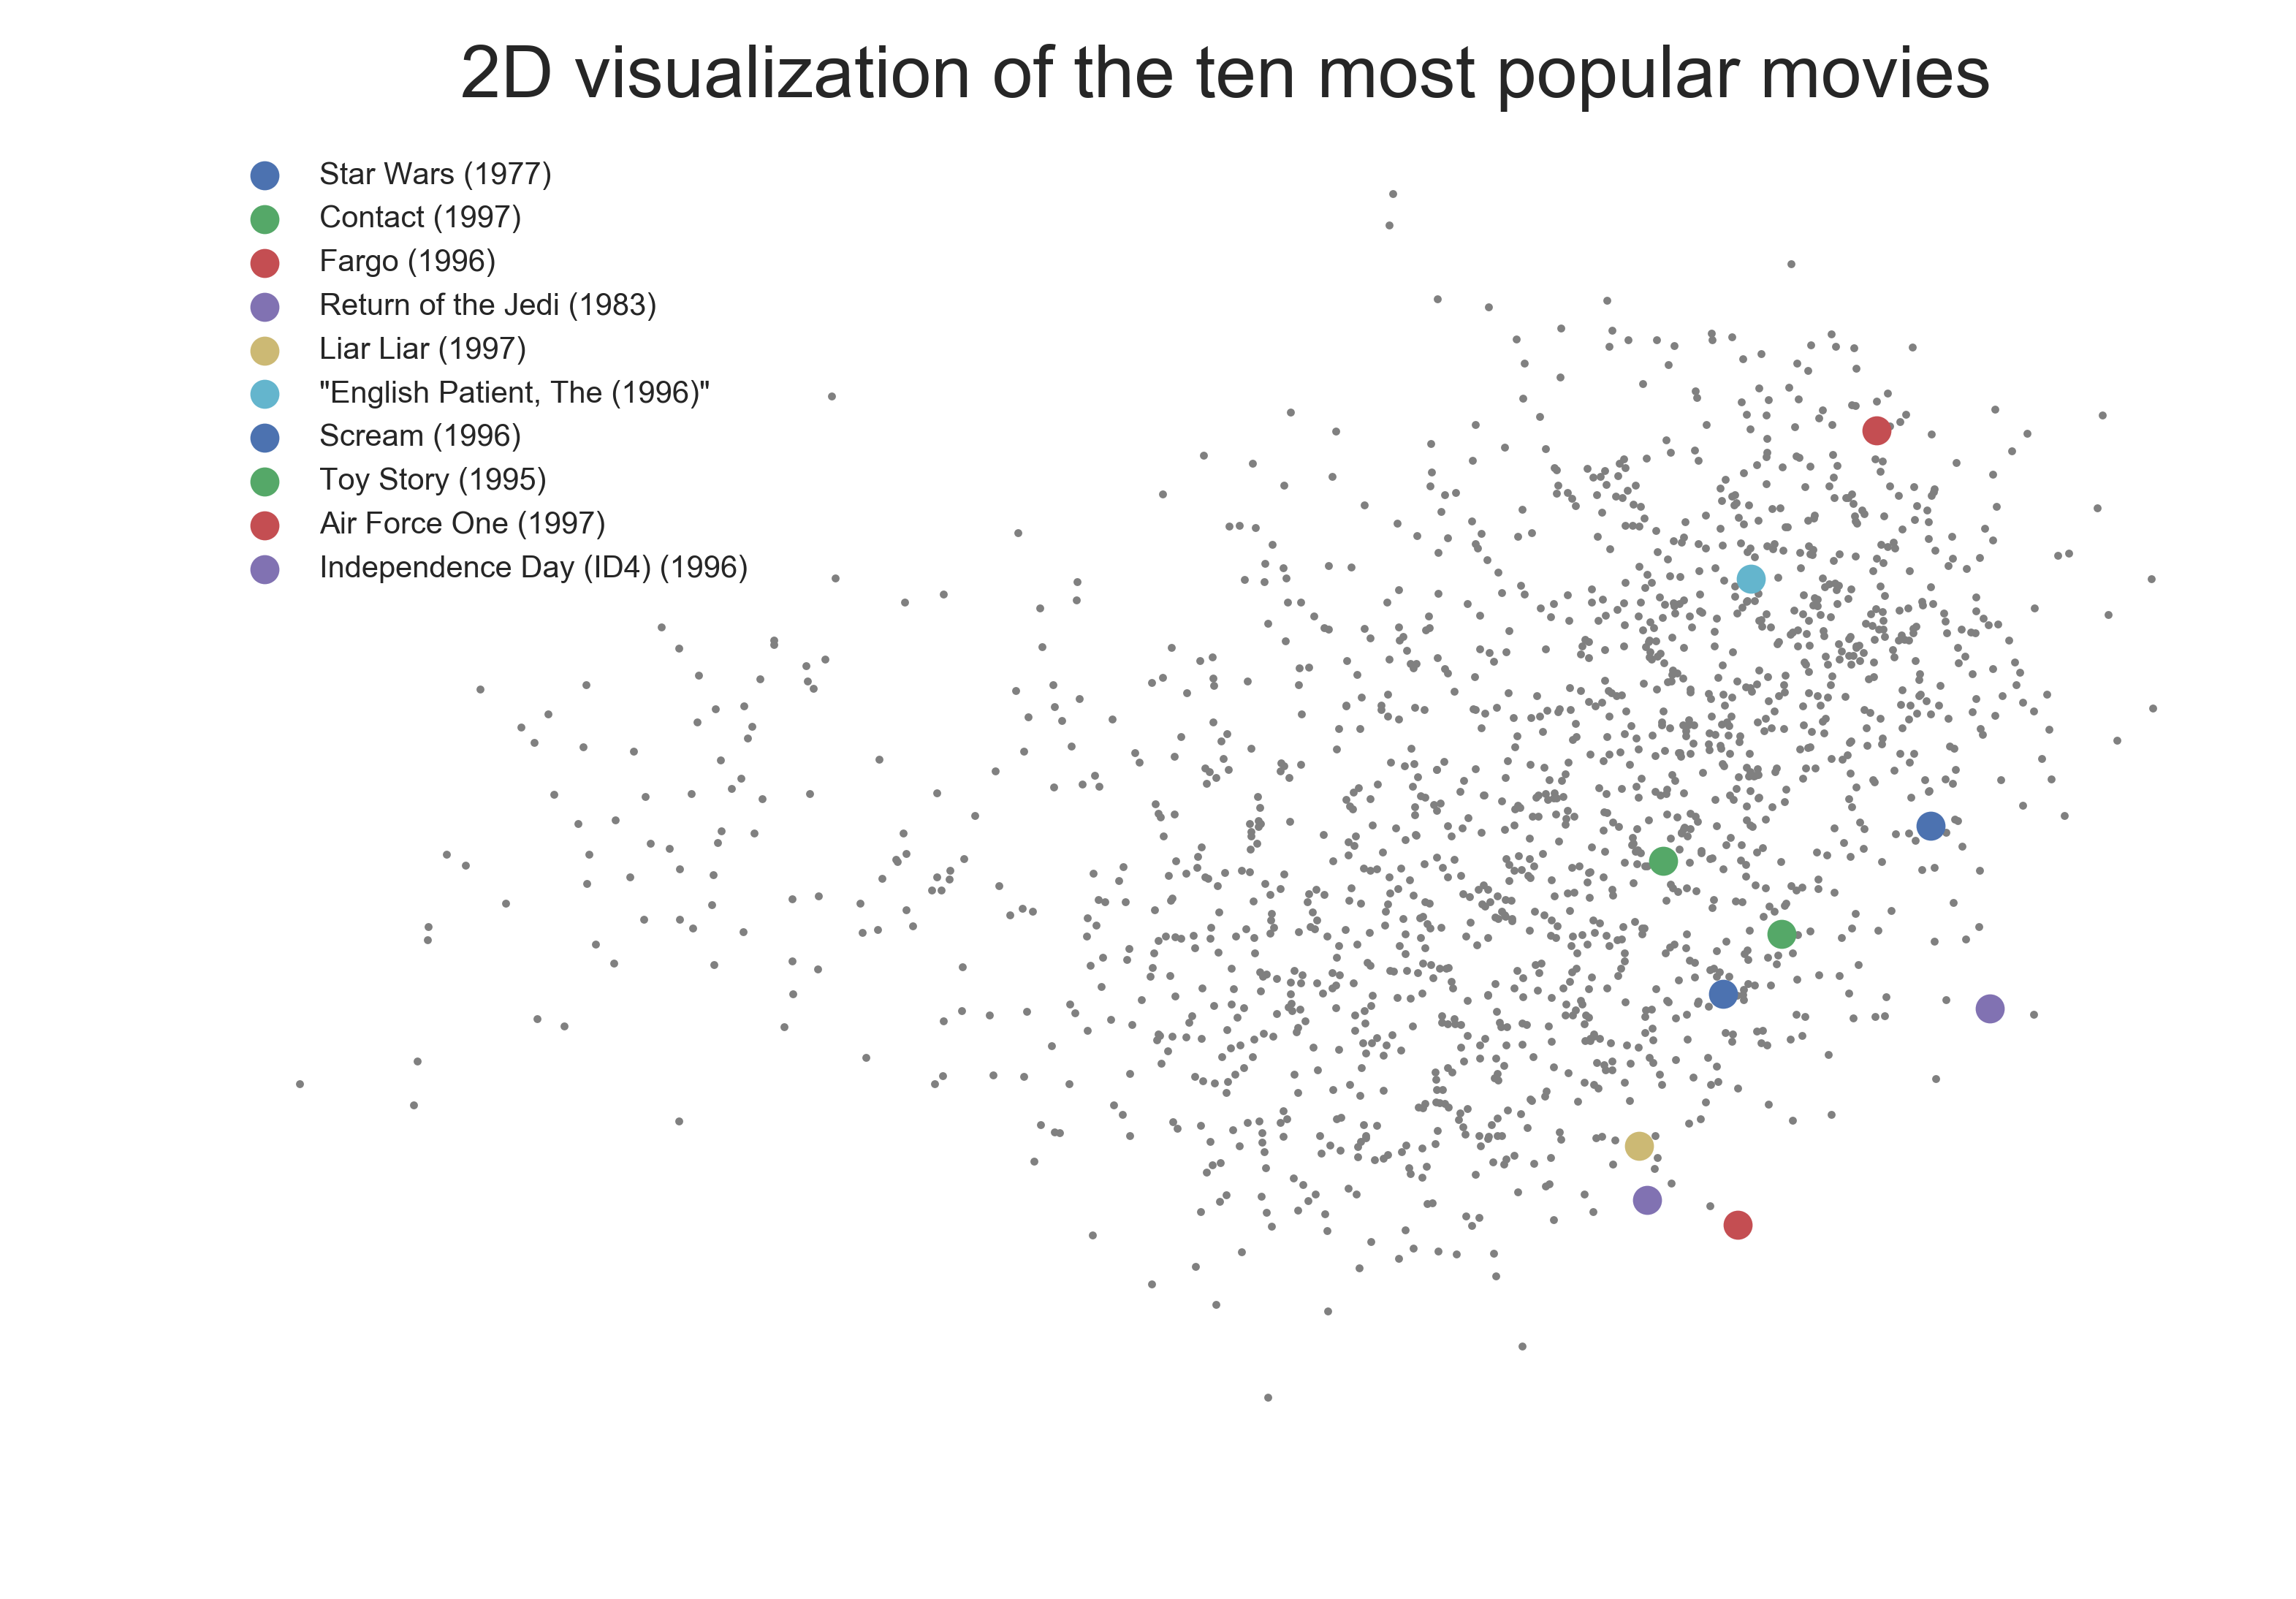

In [11]:
data = V2_simple
plt.figure(dpi=300)
plt.scatter(data[0, :], data[1, :], 1, 'gray')
ids = rank_counts[:10]
for idx in ids:
    plt.scatter(data[0, idx], data[1, idx], 20, label=movie_title[idx])
# for label, x, y in zip(movie_title[ids], data[0, ids], data[1, ids]):
#     plt.annotate(
#         label, fontsize=6,
#         xy=(x, y), xytext=(5, -5),
#         textcoords='offset points', ha='left', va='top')
plt.axis('off')
plt.legend(prop={'size': 5})
plt.title('2D visualization of the ten most popular movies')
plt.show()

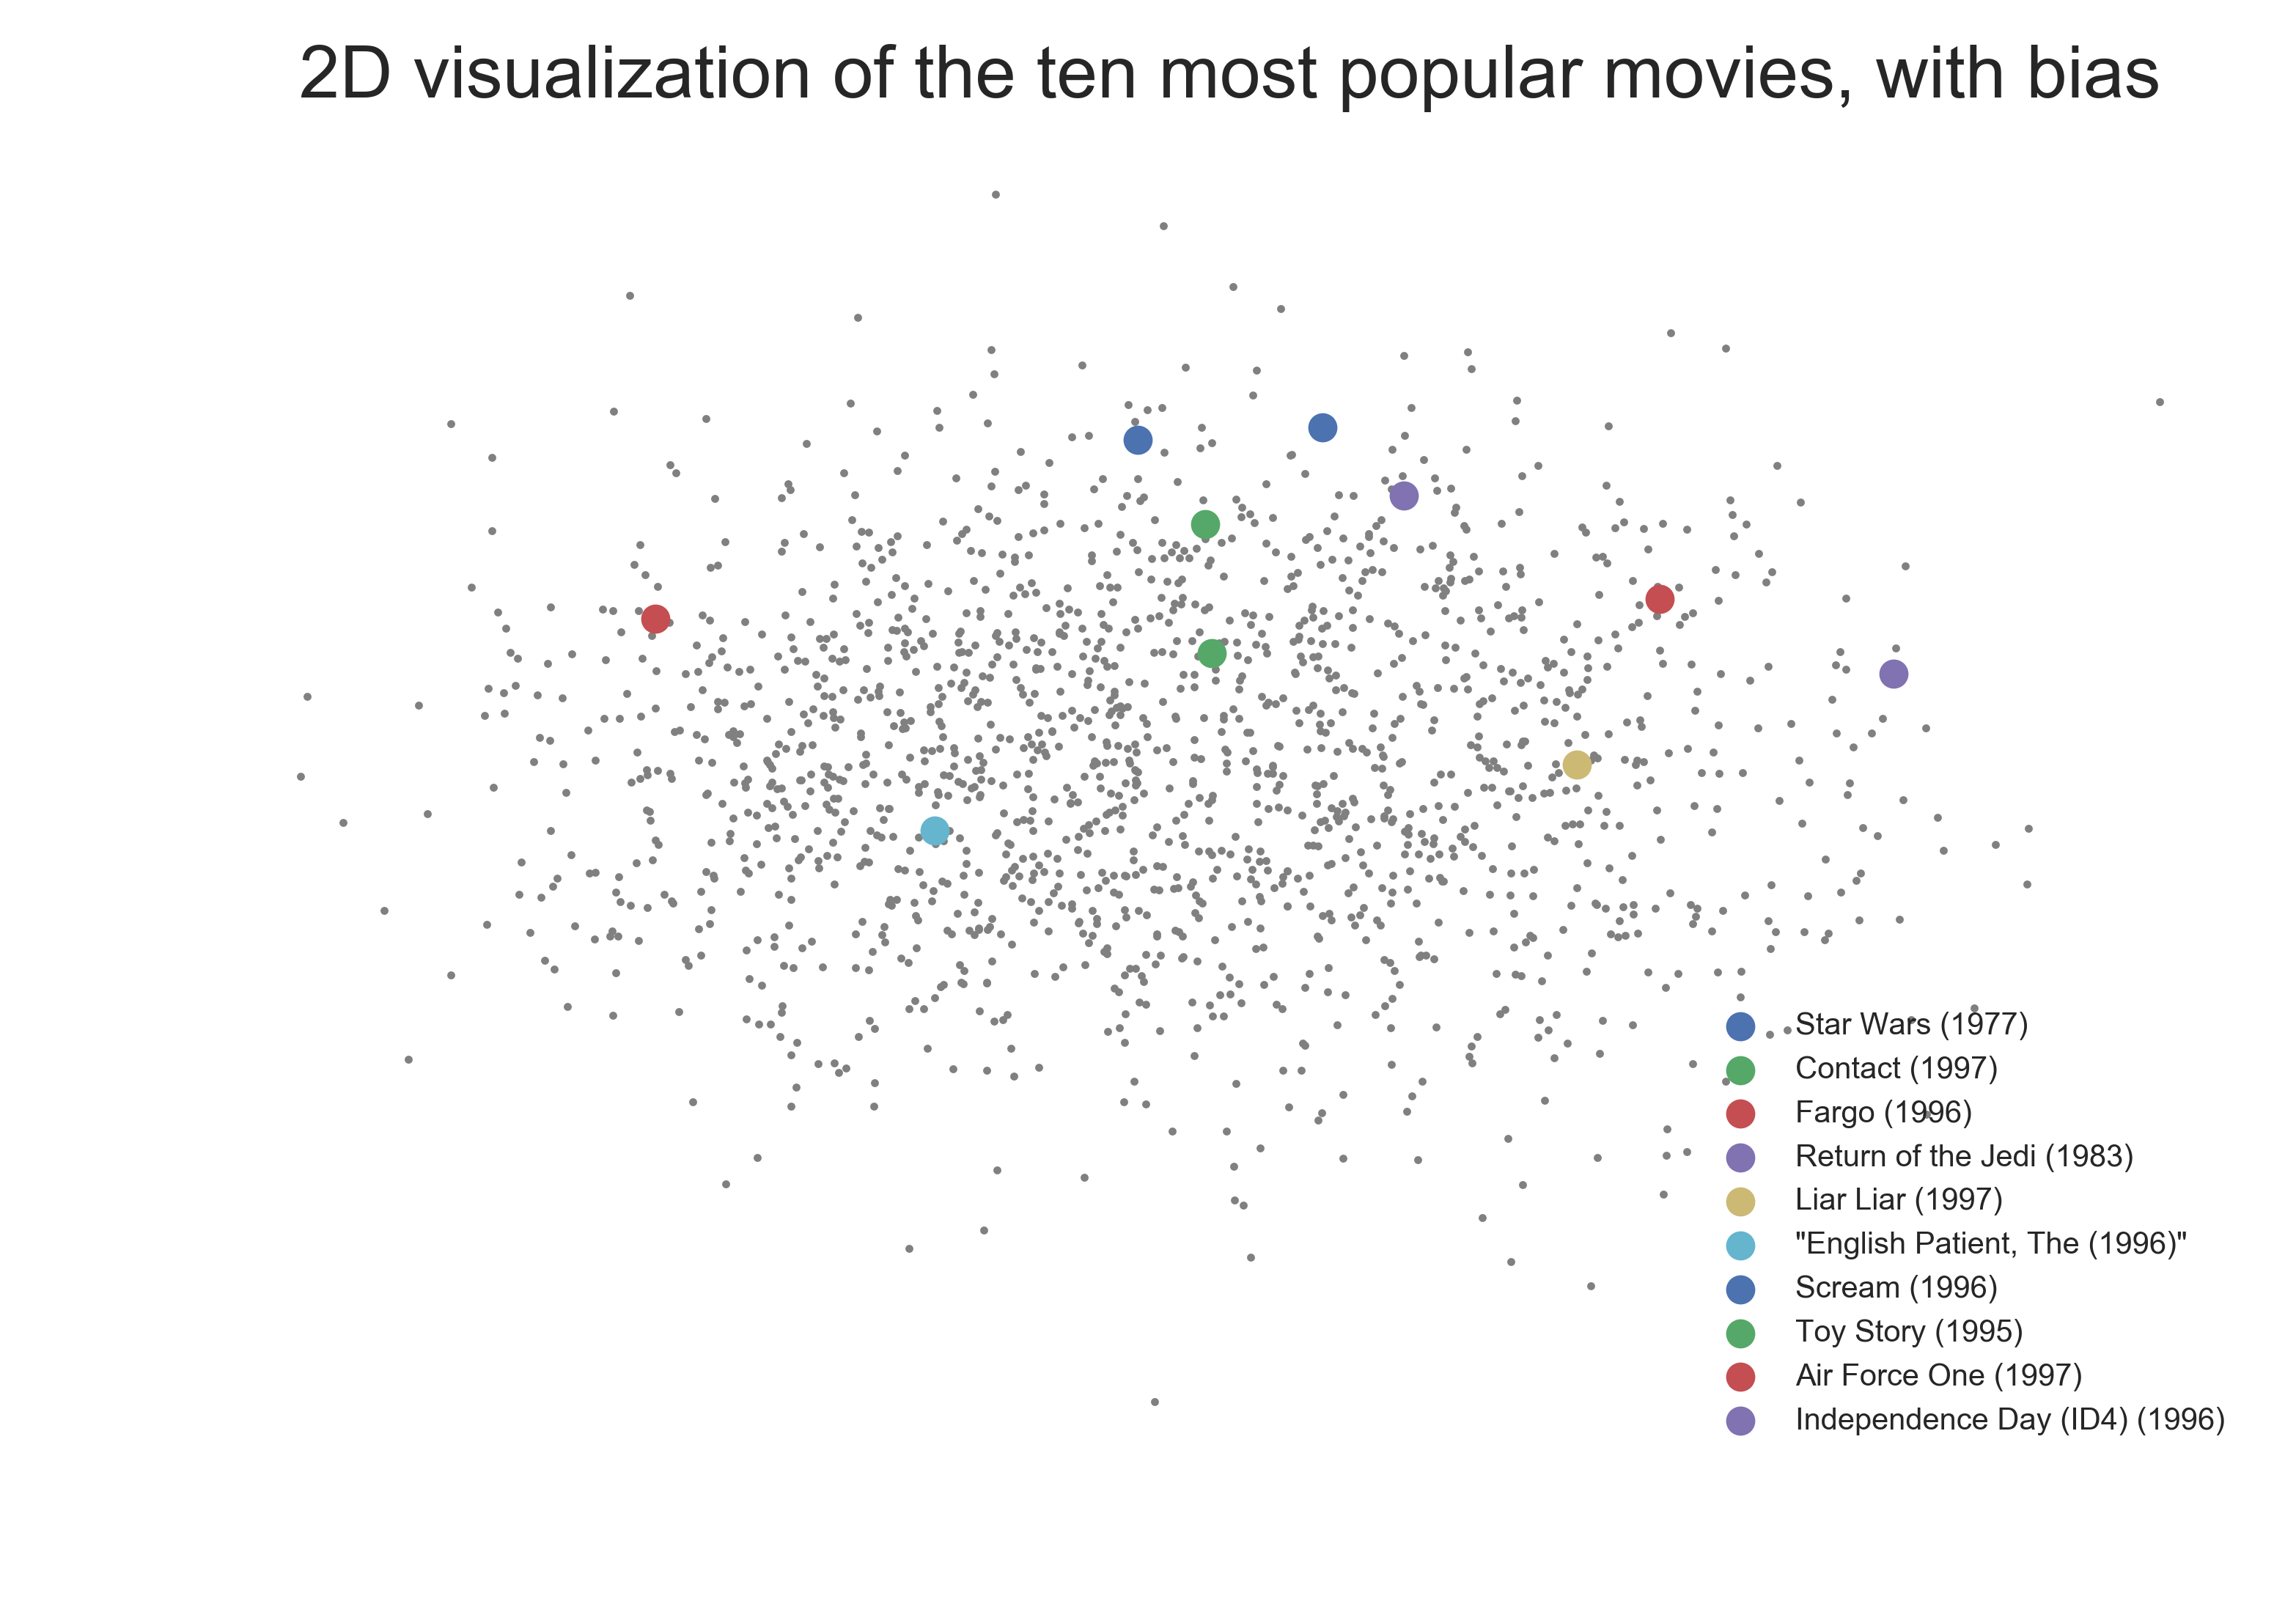

In [13]:
data = V2_bias
plt.figure(dpi=300)
plt.scatter(data[0, :], data[1, :], 1, 'gray')
ids = rank_counts[:10]
for idx in ids:
    plt.scatter(data[0, idx], data[1, idx], 20, label=movie_title[idx])
# for label, x, y in zip(movie_title[ids], data[0, ids], data[1, ids]):
#     plt.annotate(
#         label, fontsize=6,
#         xy=(x, y), xytext=(5, -5),
#         textcoords='offset points', ha='left', va='top')
plt.axis('off')
plt.legend(prop={'size': 5})
plt.title('2D visualization of the ten most popular movies, with bias')
plt.show()

In [12]:
plt.figure(dpi=300)
plt.scatter(V2[0, :], V2[1, :], 5, counts, cmap='viridis')
plt.title('2D visualization of number of movie ratings')
plt.colorbar()
plt.axis('off')
plt.show()

NameError: name 'V2' is not defined

## ) Movie genres

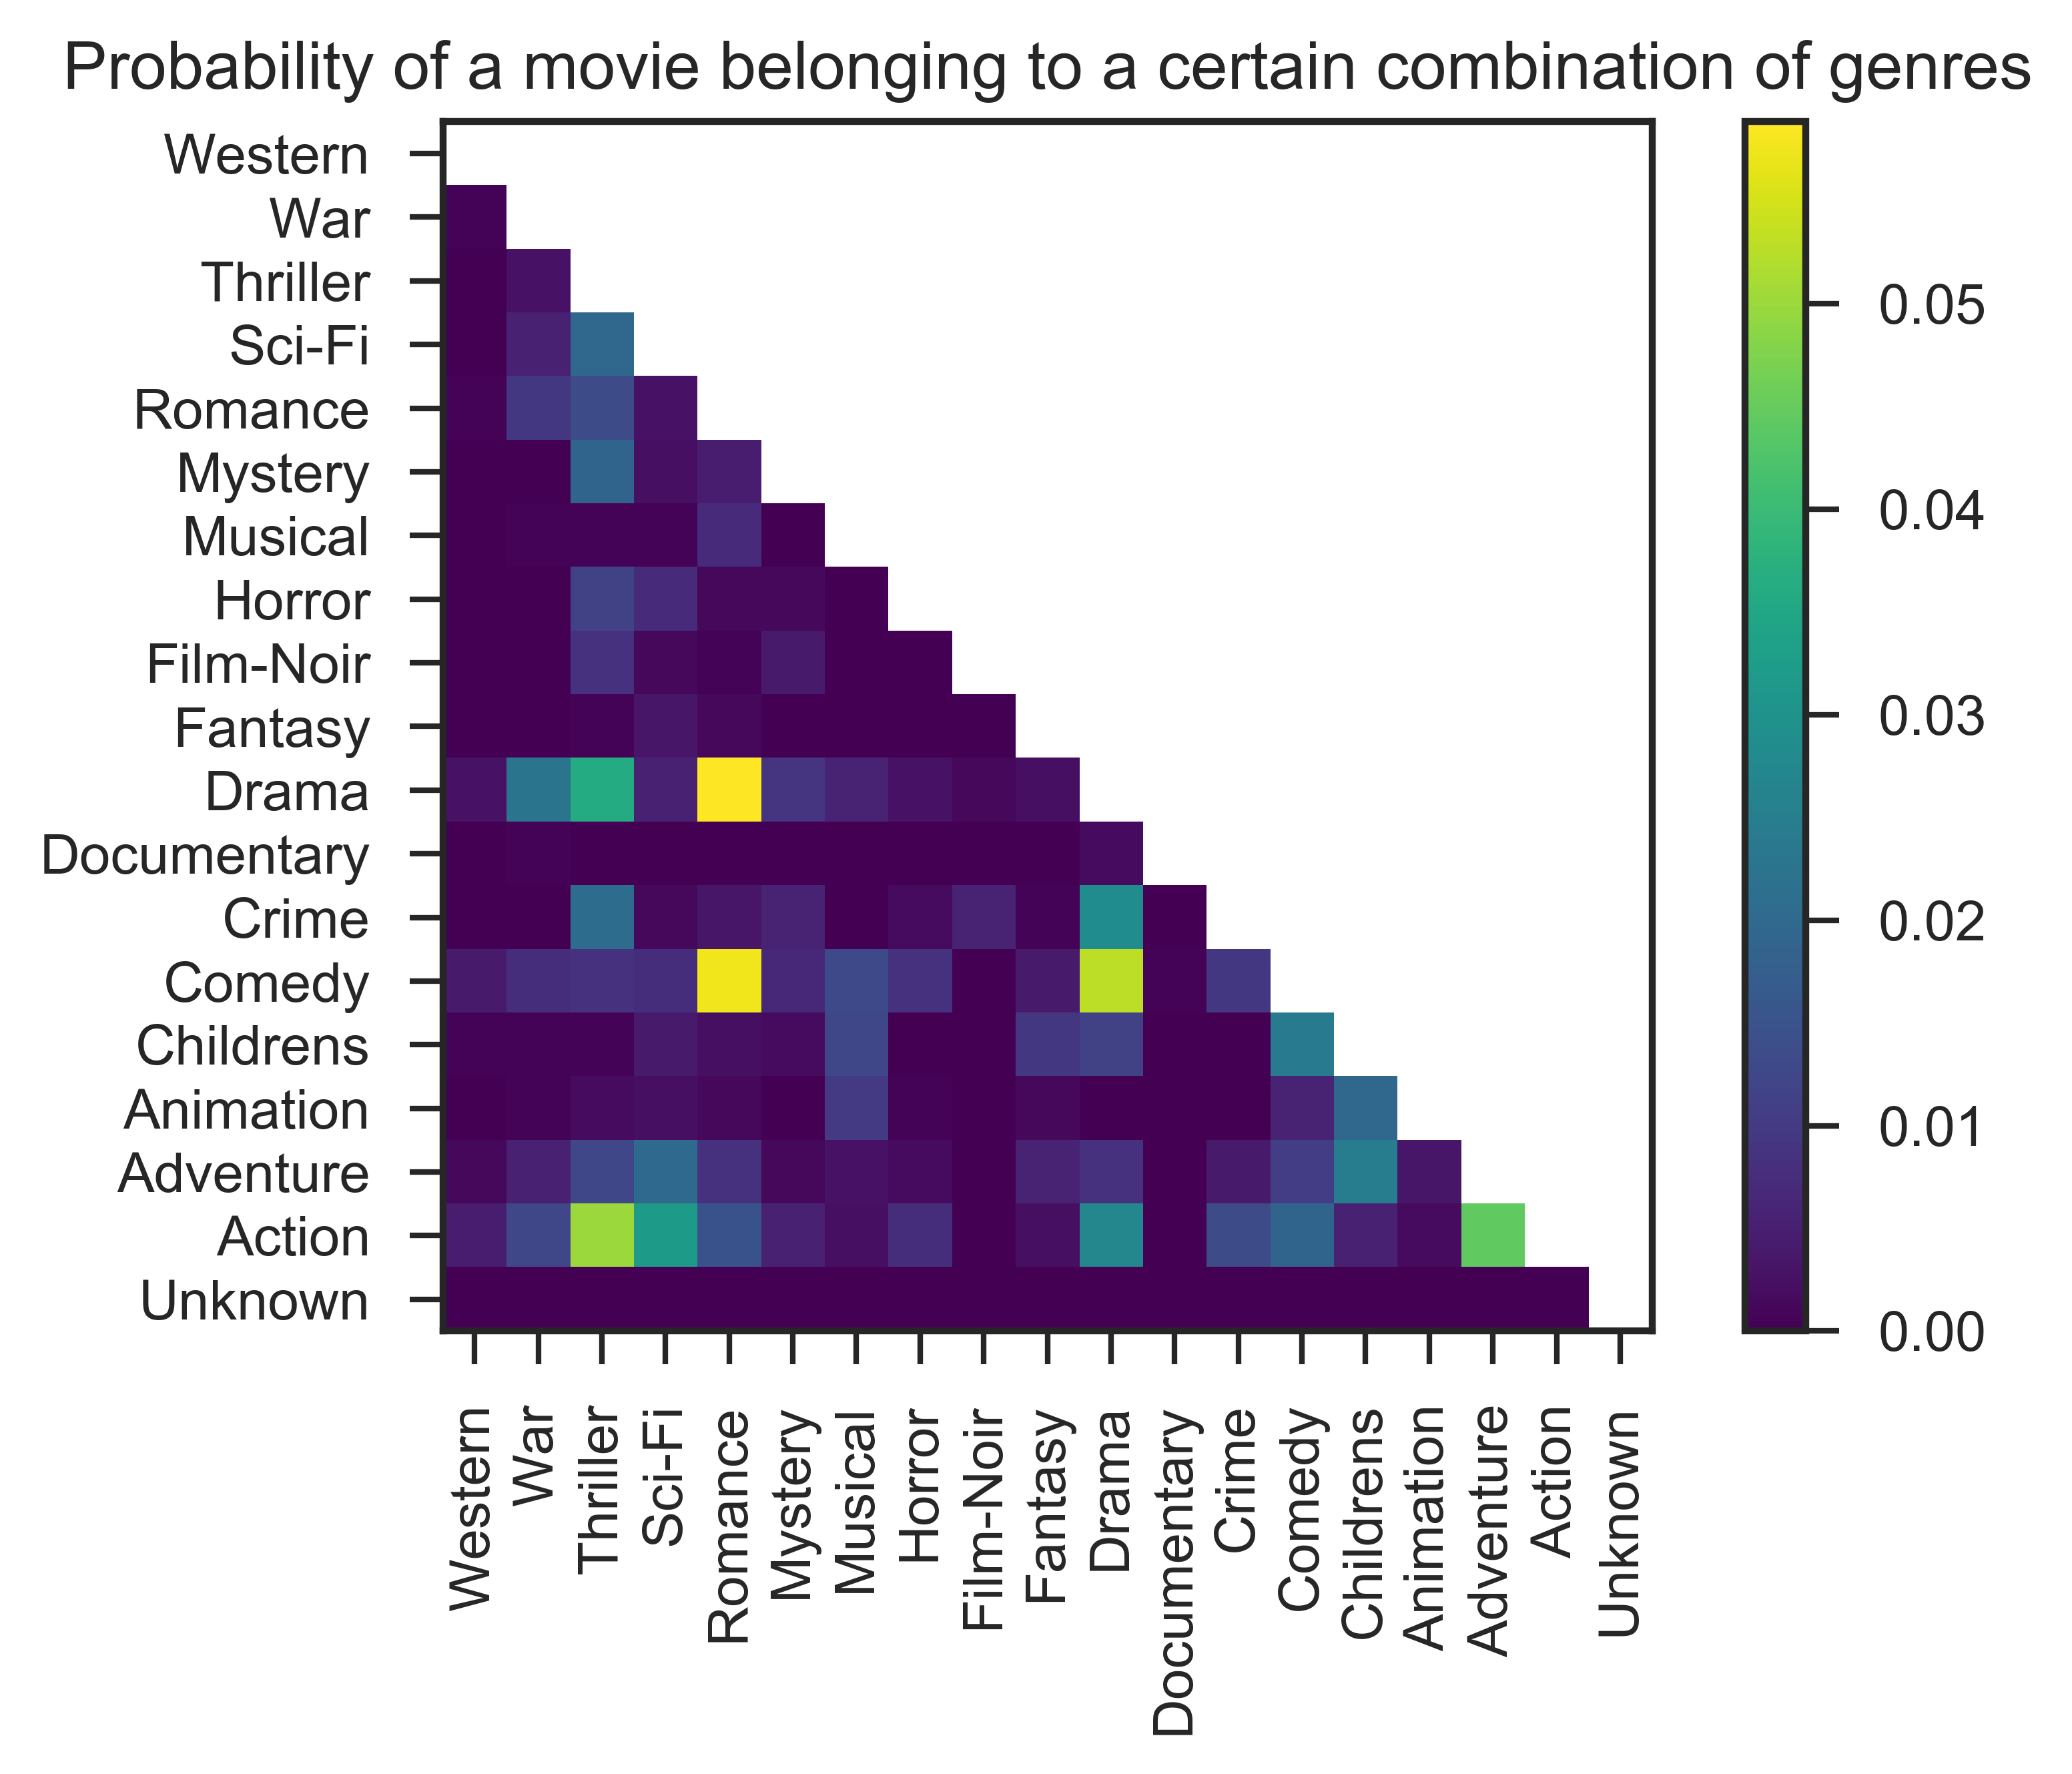

In [14]:
sns.set_style("ticks")
n_genres = len(genres)
genre_similarity_nodiag = genre_similarity.copy()
for i in range(n_genres):
    genre_similarity_nodiag[i, i] = np.nan
plt.figure(dpi=300)
plt.imshow(np.rot90(genre_similarity_nodiag, 2), extent=[0.5, n_genres+0.5, 0.5, n_genres+0.5],
          cmap='viridis')
plt.xticks(np.arange(n_genres)+1, genres[::-1], rotation='vertical')
plt.yticks(np.arange(n_genres)+1, genres)
plt.colorbar()
plt.title('Probability of a movie belonging to a certain combination of genres')
plt.show()

In [15]:
genre_freq = np.diag(genre_similarity)
V_bias_genre = V_bias@movie_genre
print((V_bias_genre/genre_freq).shape, genre_freq.shape)

(20, 19) (19,)


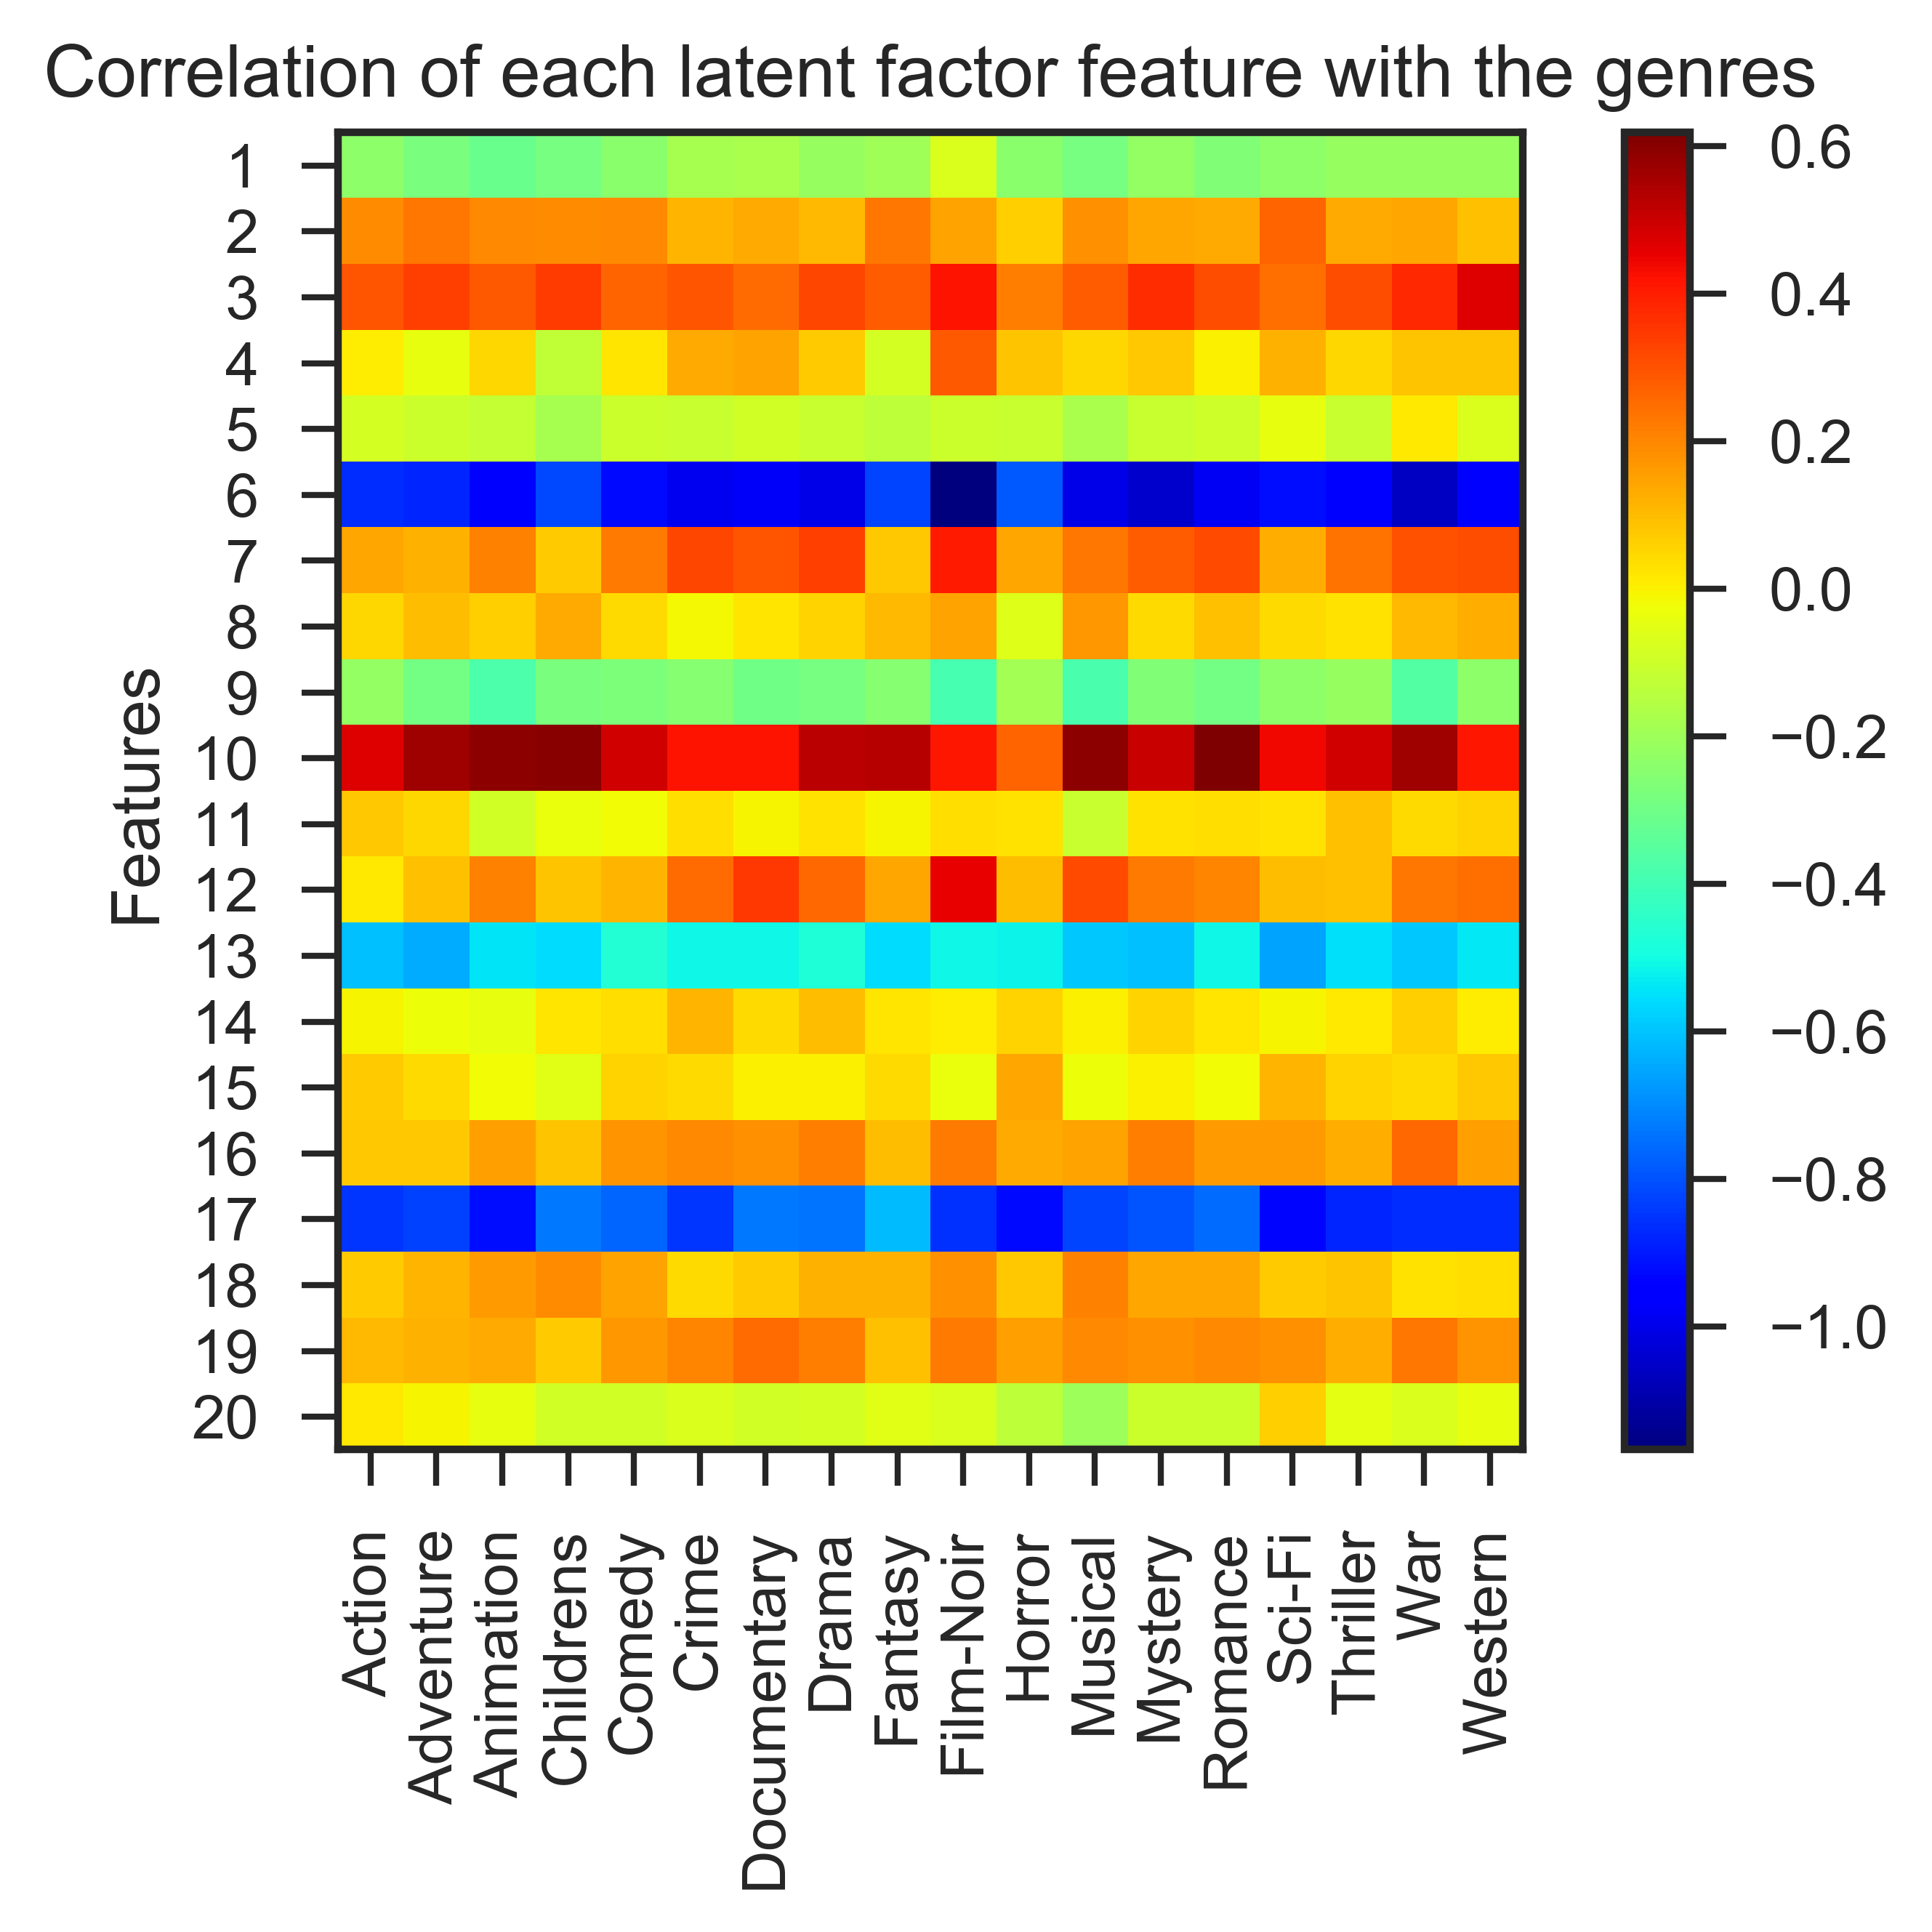

In [16]:
genre_freq = np.diag(genre_similarity)
V_simple_genre = V_simple@movie_genre/genre_freq/N

sns.set_style("ticks")
n_genres = len(genres)
plt.figure(dpi=300)
plt.imshow(V_simple_genre[:, 1:], 
           extent=[0.5, n_genres-0.5, 0.5, K+0.5],
           cmap='jet')
plt.xticks(np.arange(n_genres-1)+1, genres[1:], rotation='vertical')
plt.yticks(np.arange(K)+1, (np.arange(K)+1)[::-1])
plt.ylabel('Features')
plt.colorbar()
plt.title('Correlation of each latent factor feature with the genres')
plt.show()

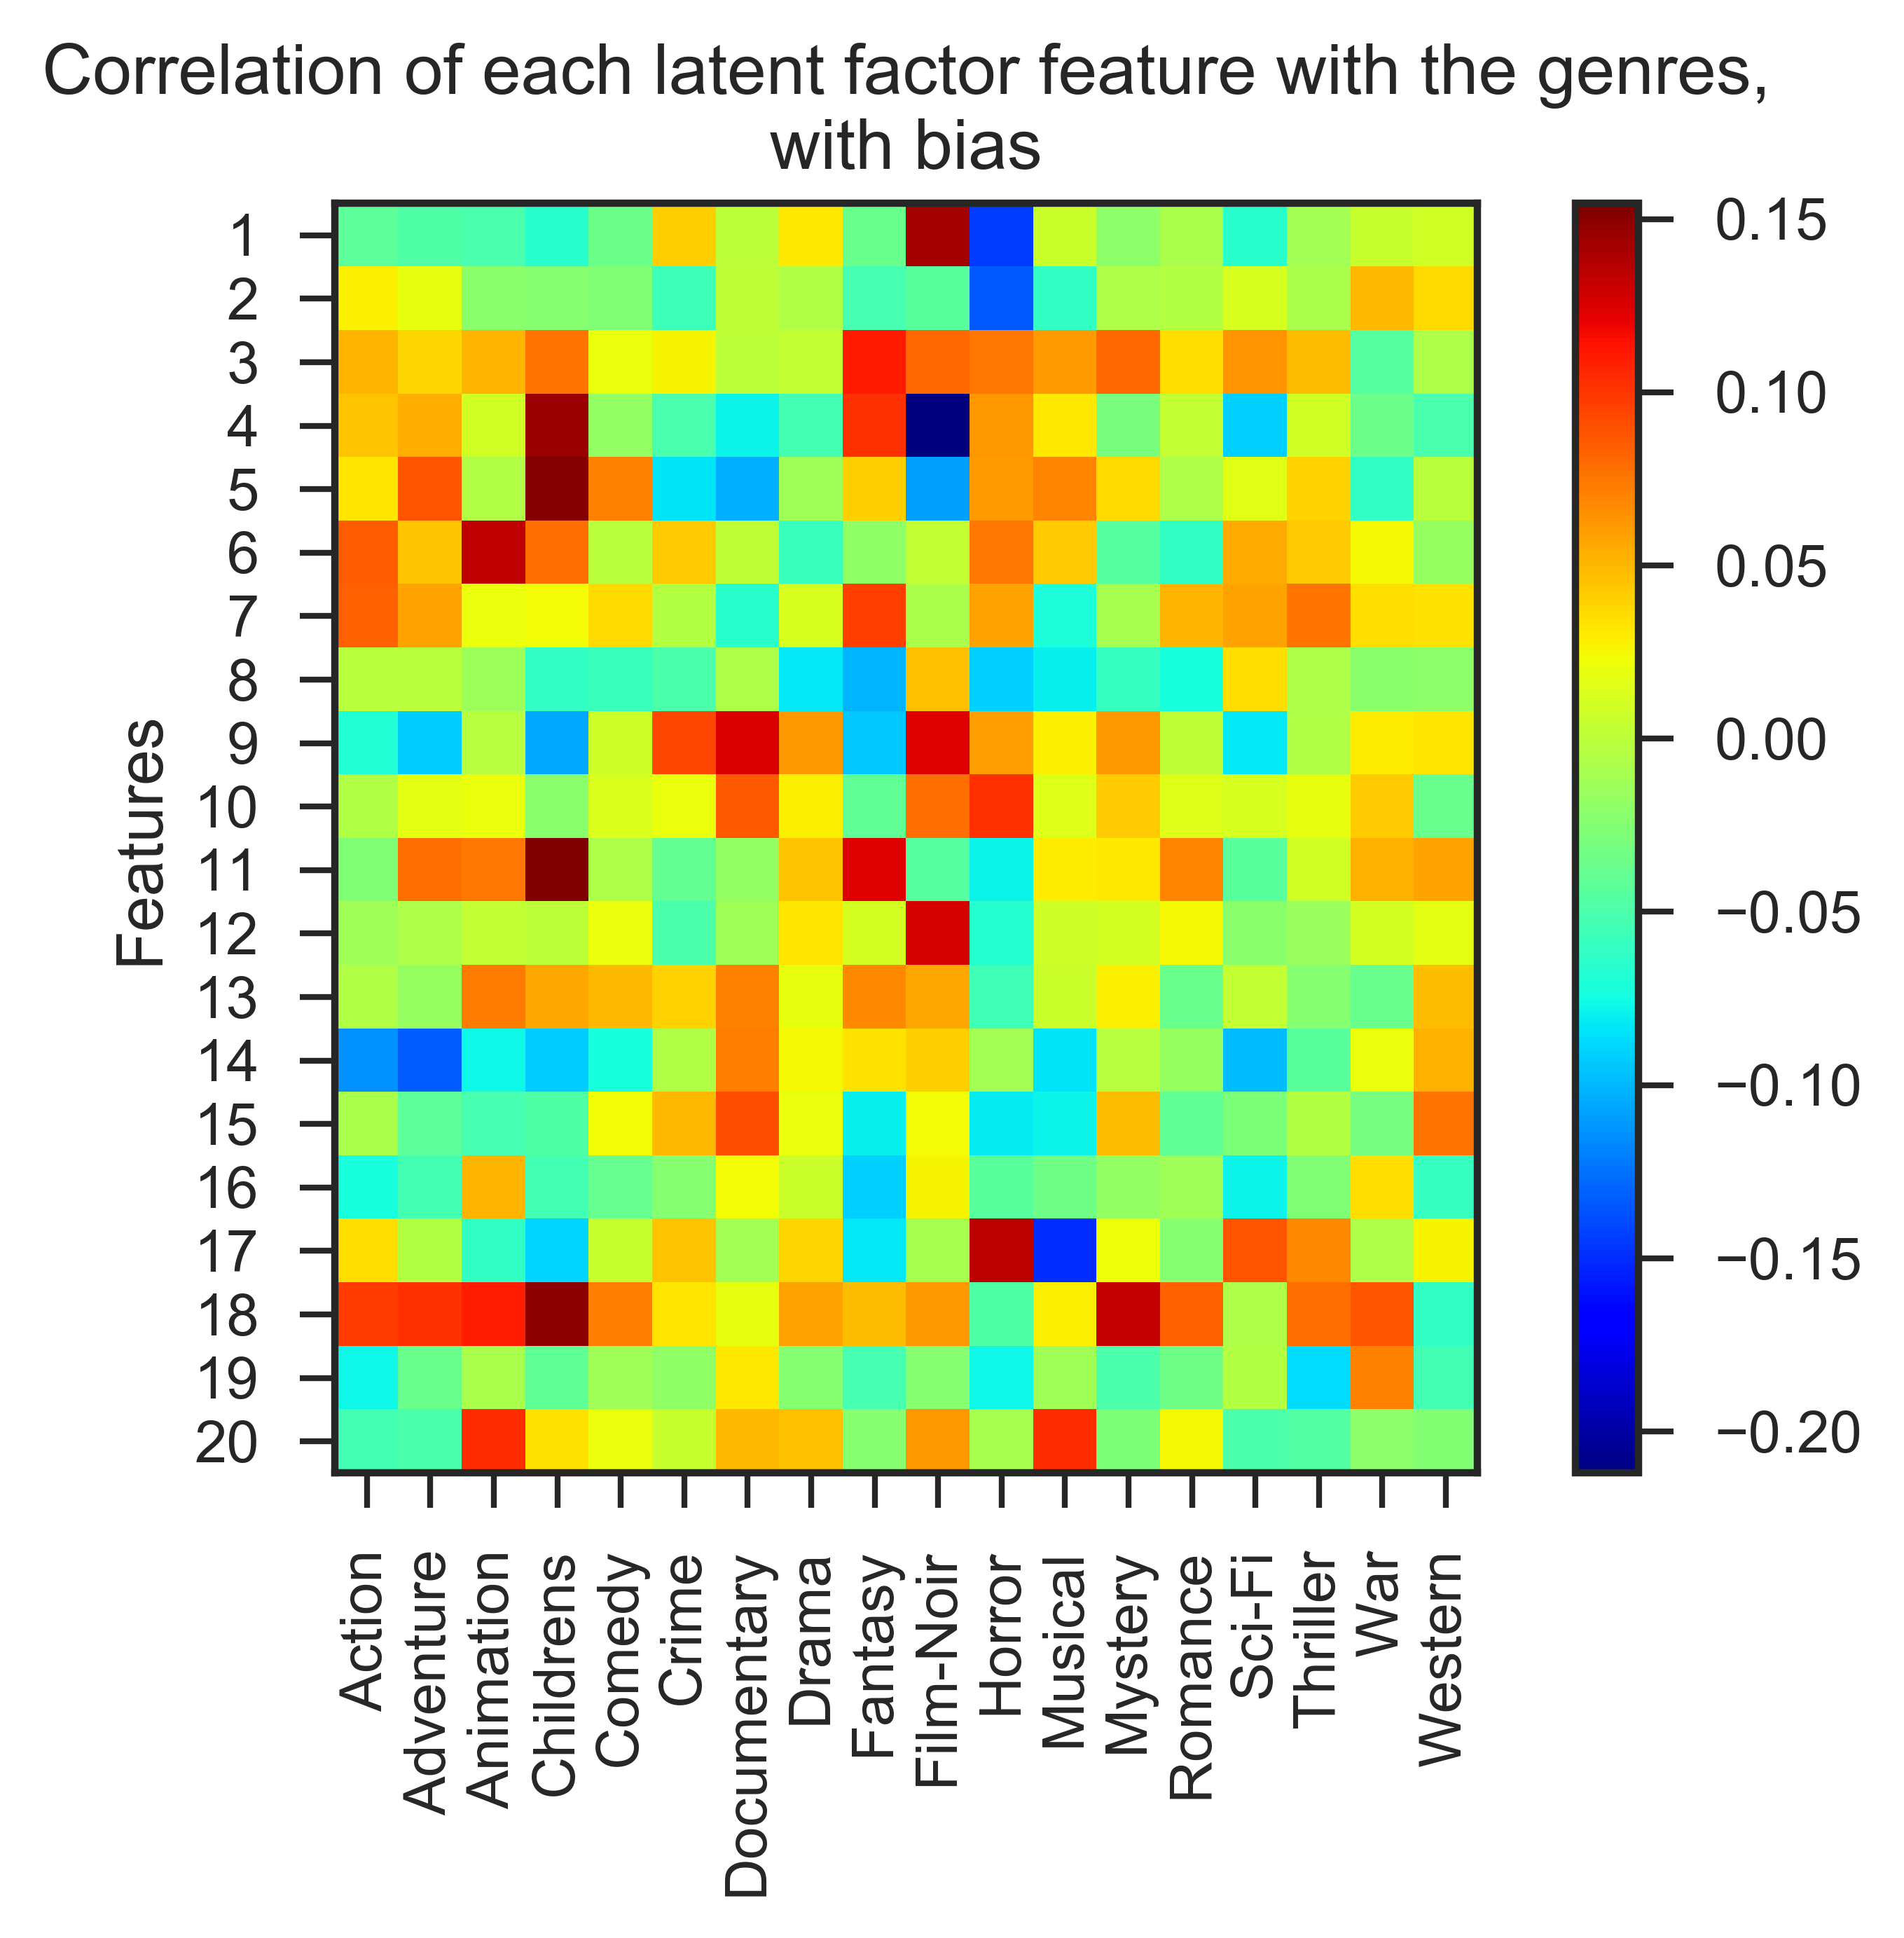

In [17]:
genre_freq = np.diag(genre_similarity)
V_bias_genre = V_bias@movie_genre/genre_freq/N

sns.set_style("ticks")
n_genres = len(genres)
plt.figure(dpi=300)
plt.imshow(V_bias_genre[:, 1:], 
           extent=[0.5, n_genres-0.5, 0.5, K+0.5],
           cmap='jet')
plt.xticks(np.arange(n_genres-1)+1, genres[1:], rotation='vertical')
plt.yticks(np.arange(K)+1, (np.arange(K)+1)[::-1])
plt.ylabel('Features')
plt.colorbar()
plt.title('Correlation of each latent factor feature with the genres,\nwith bias')
plt.show()

## c) Ten Best Movies

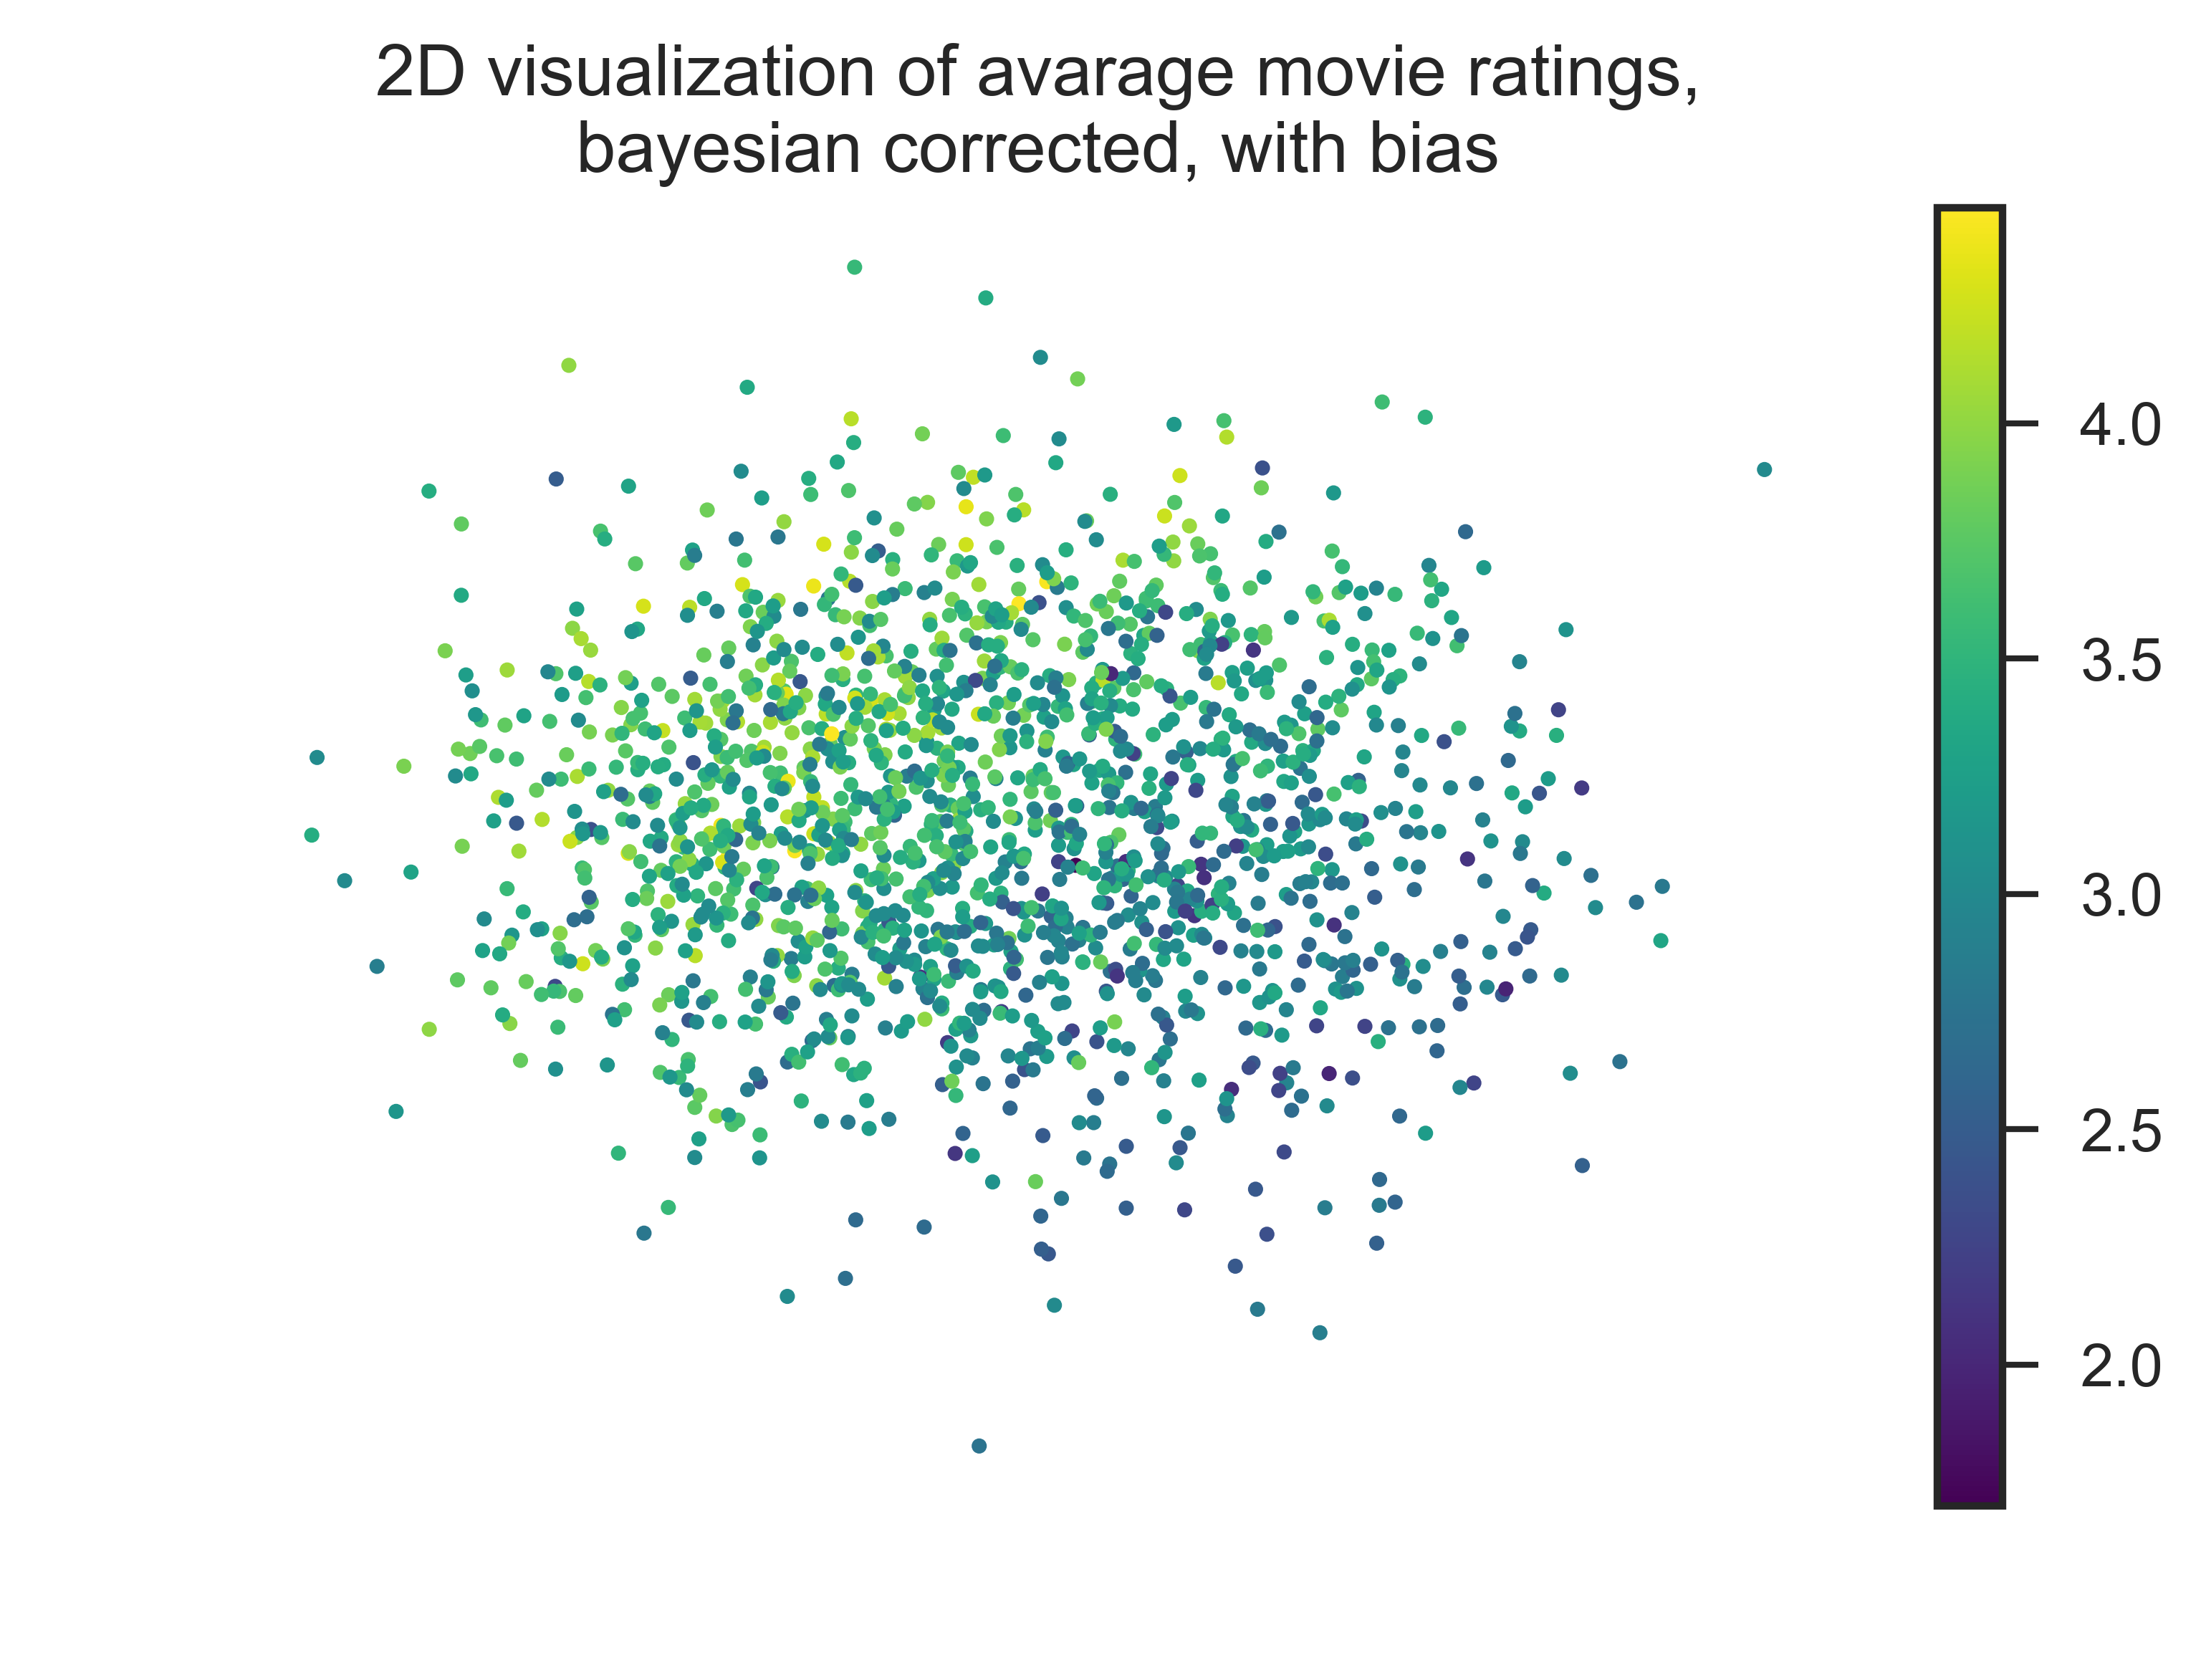

In [18]:
data = V2_bias
plt.figure(dpi=300)
plt.scatter(data[0, :], data[1, :], 5, ratings_bayesian, cmap='viridis')
plt.title('2D visualization of avarage movie ratings,\nbayesian corrected, with bias')
plt.colorbar()
plt.axis('off')
plt.show()

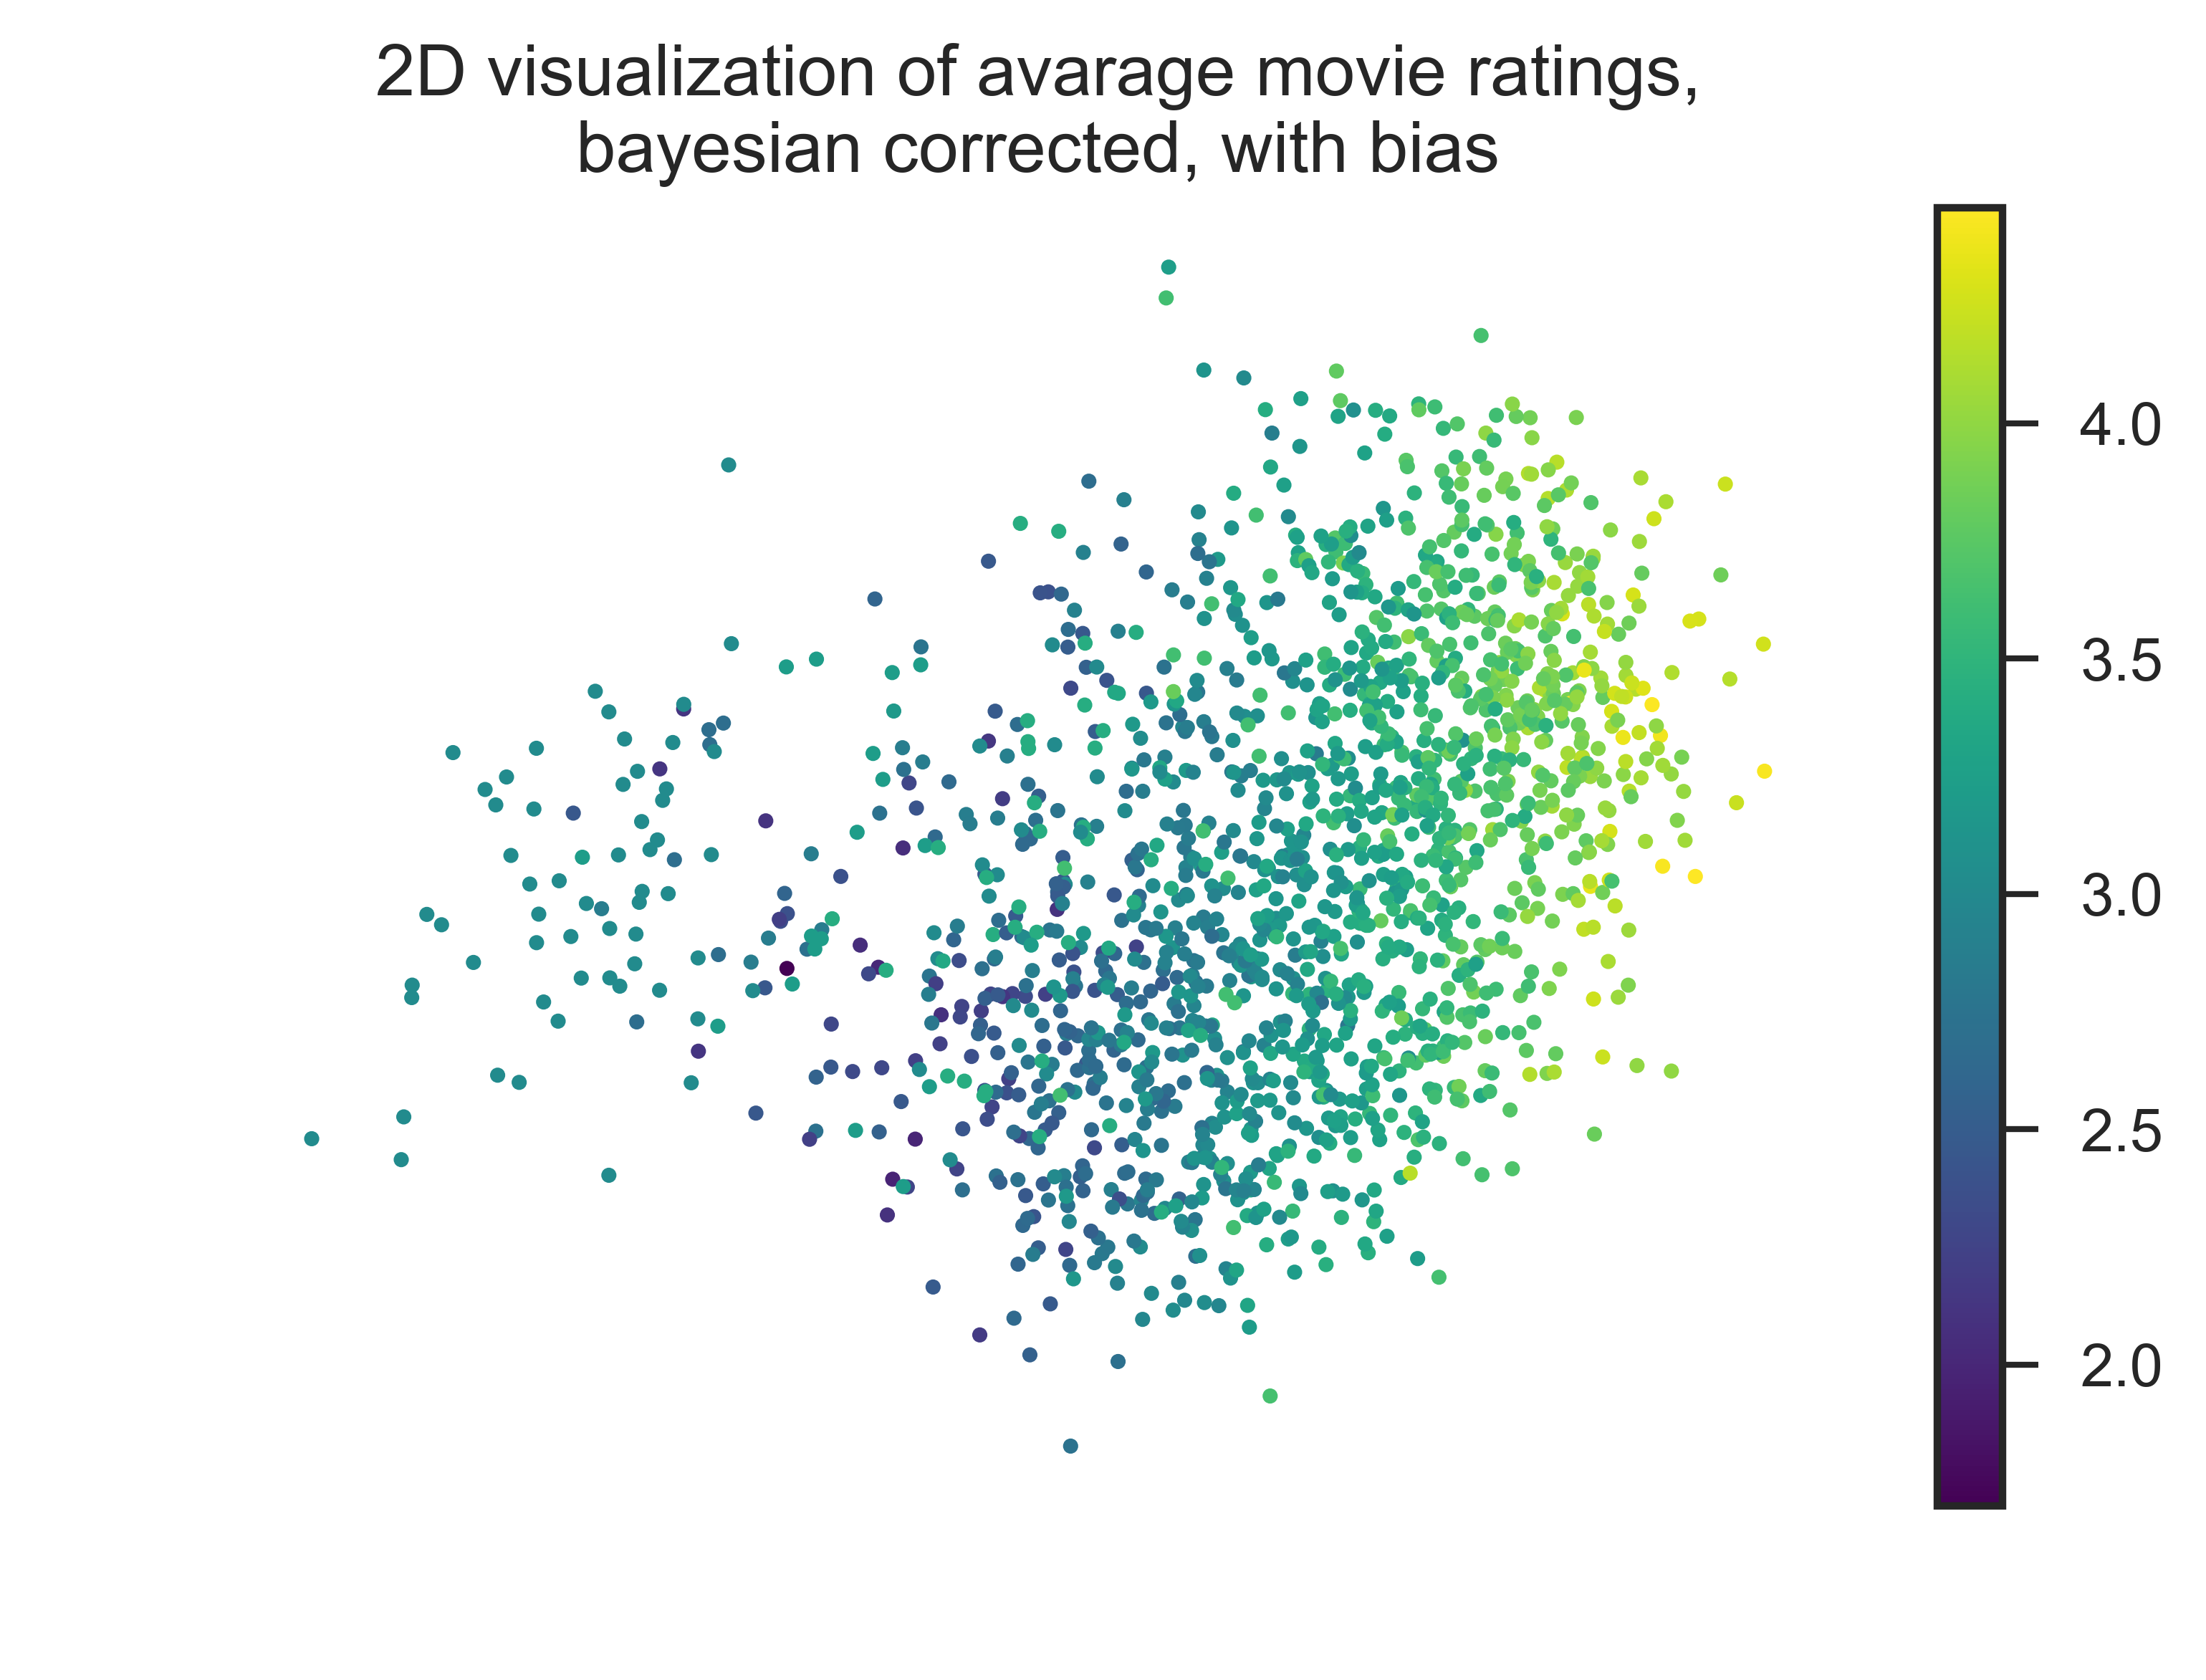

In [30]:
data = V2_simple
plt.figure(dpi=300)
plt.scatter(data[0, :], data[1, :], 5, ratings_bayesian, cmap='viridis')
plt.title('2D visualization of avarage movie ratings,\nbayesian corrected, with bias')
plt.colorbar()
plt.axis('off')
plt.show()

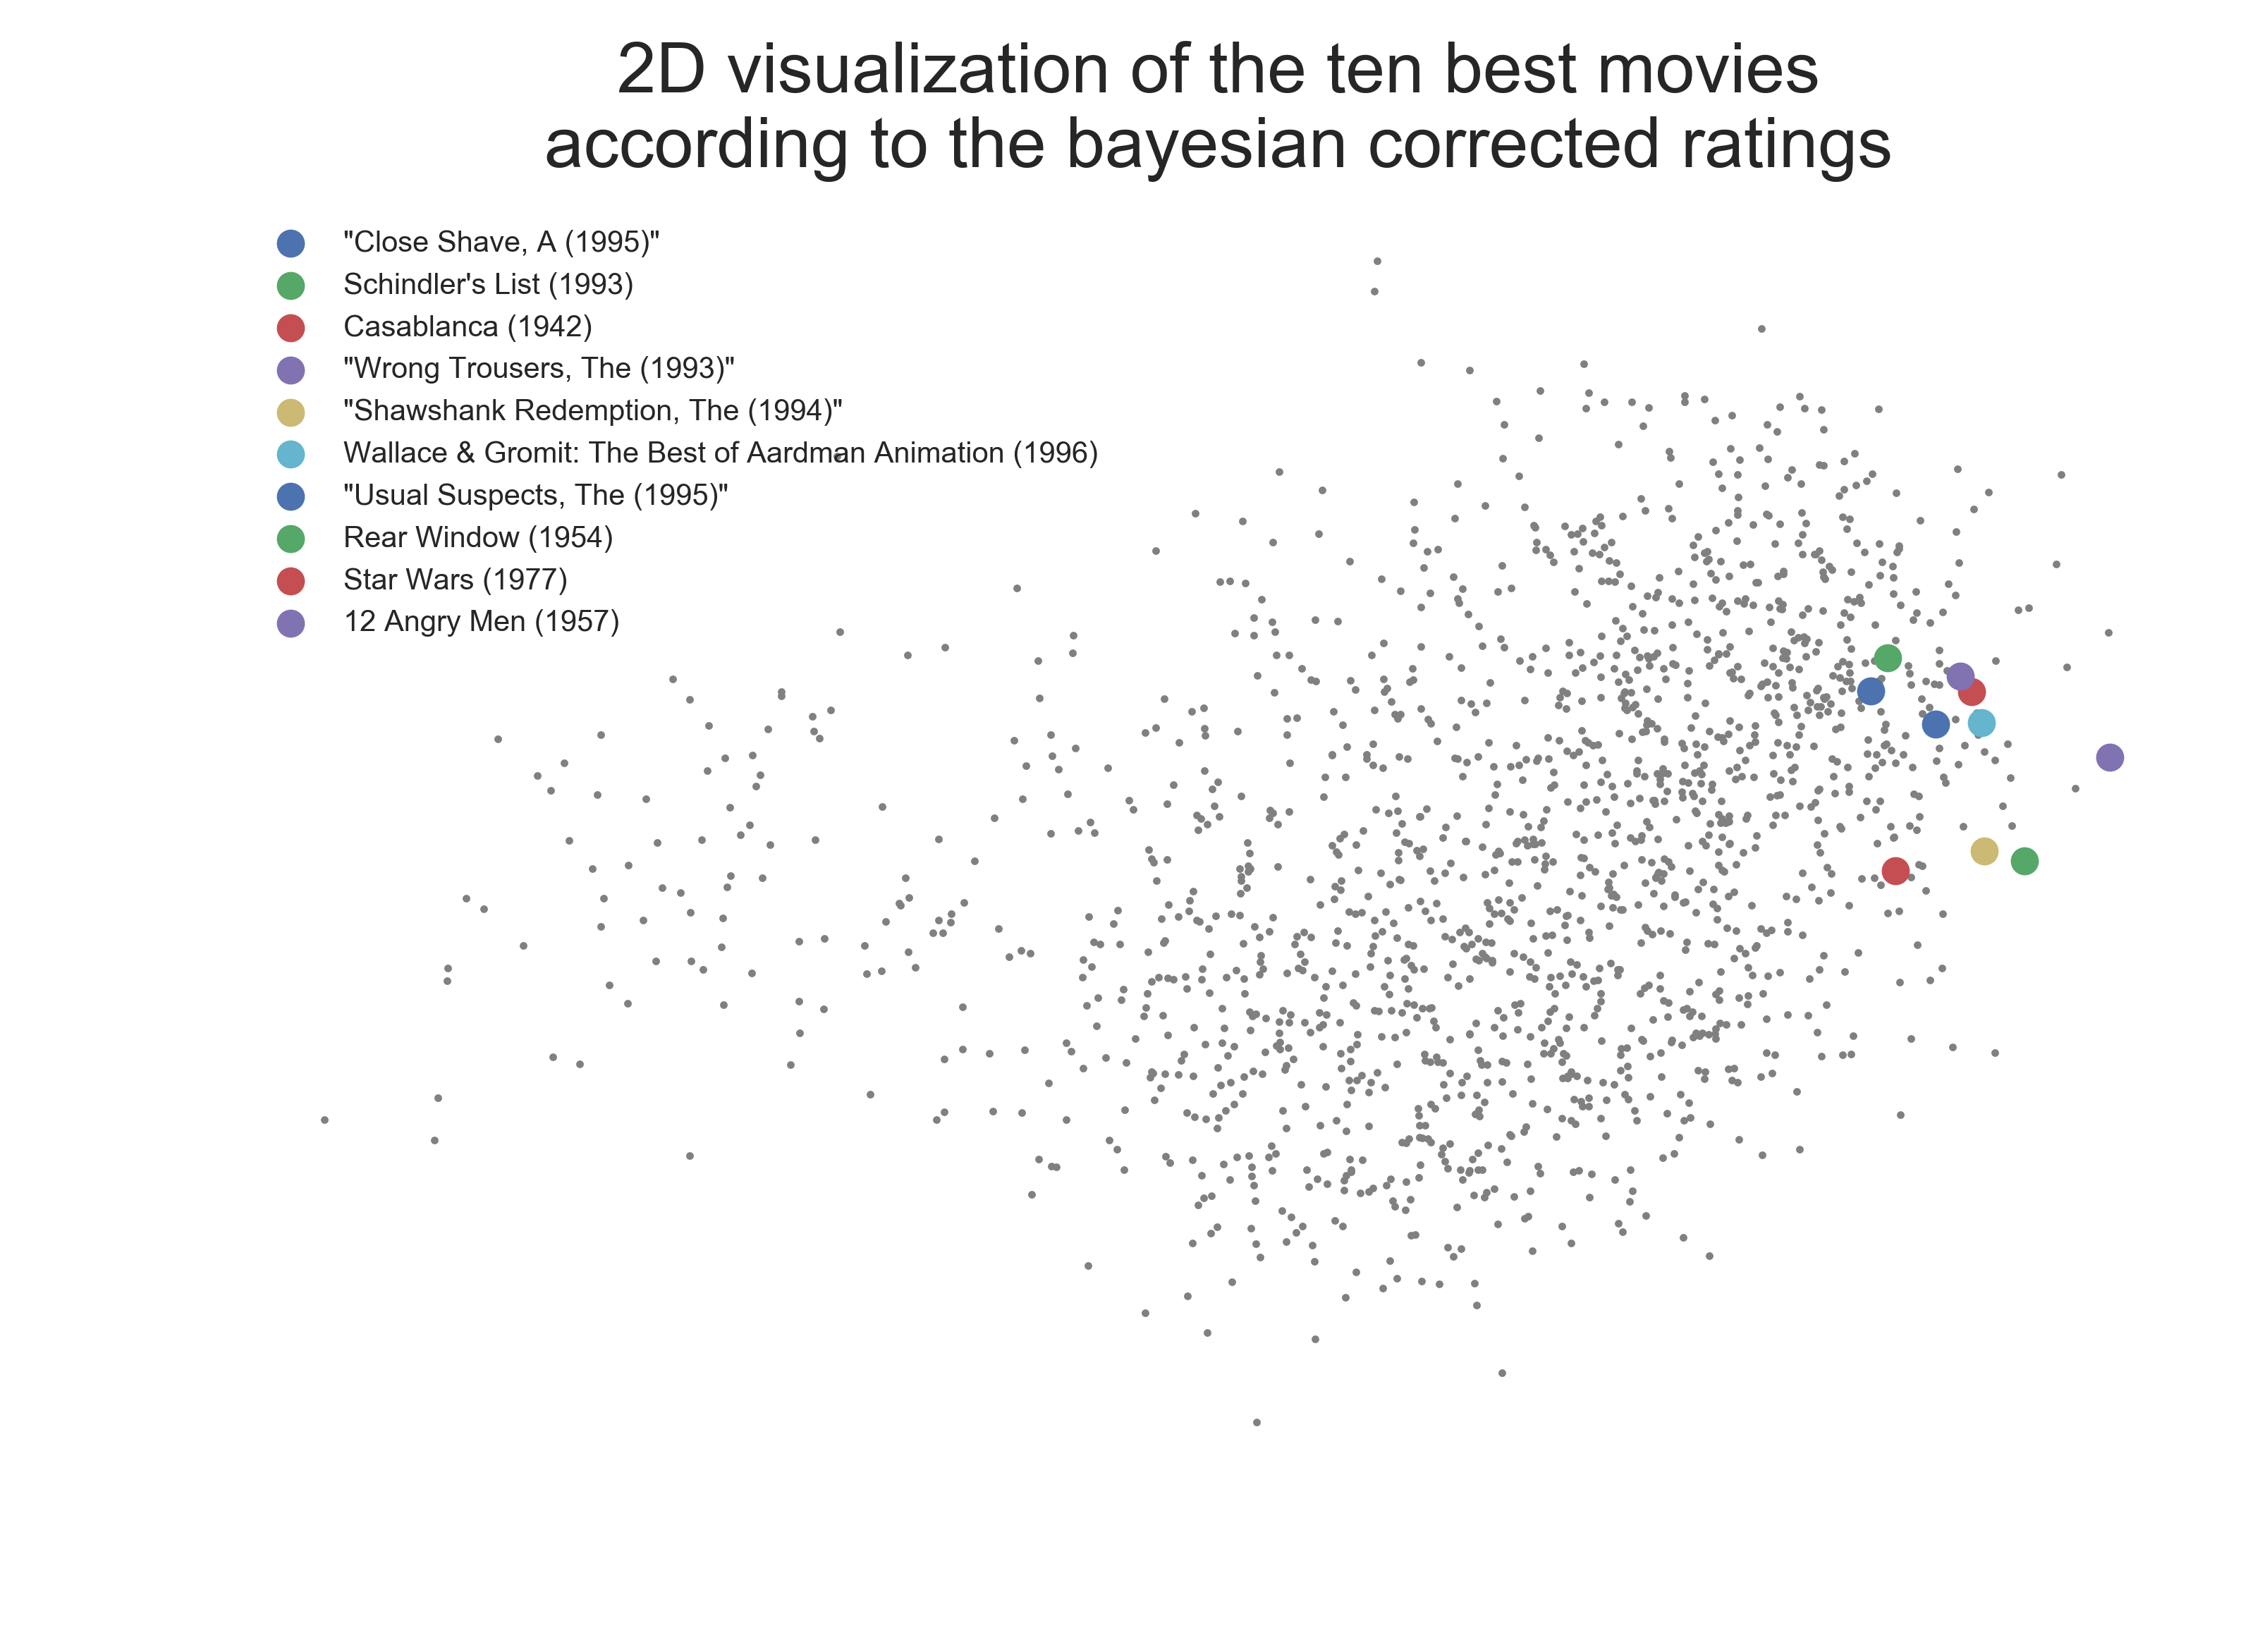

In [27]:
data = V2_simple
plt.figure(dpi=300)
plt.scatter(data[0, :], data[1, :], 1, 'gray')
for idx in rank_ratings_bayesian[:10]:
    plt.scatter(data[0, idx], data[1, idx], 20, label=movie_title[idx])
plt.axis('off')
plt.legend(prop={'size': 5})
plt.title('2D visualization of the ten best movies\naccording to the bayesian corrected ratings')
plt.show()

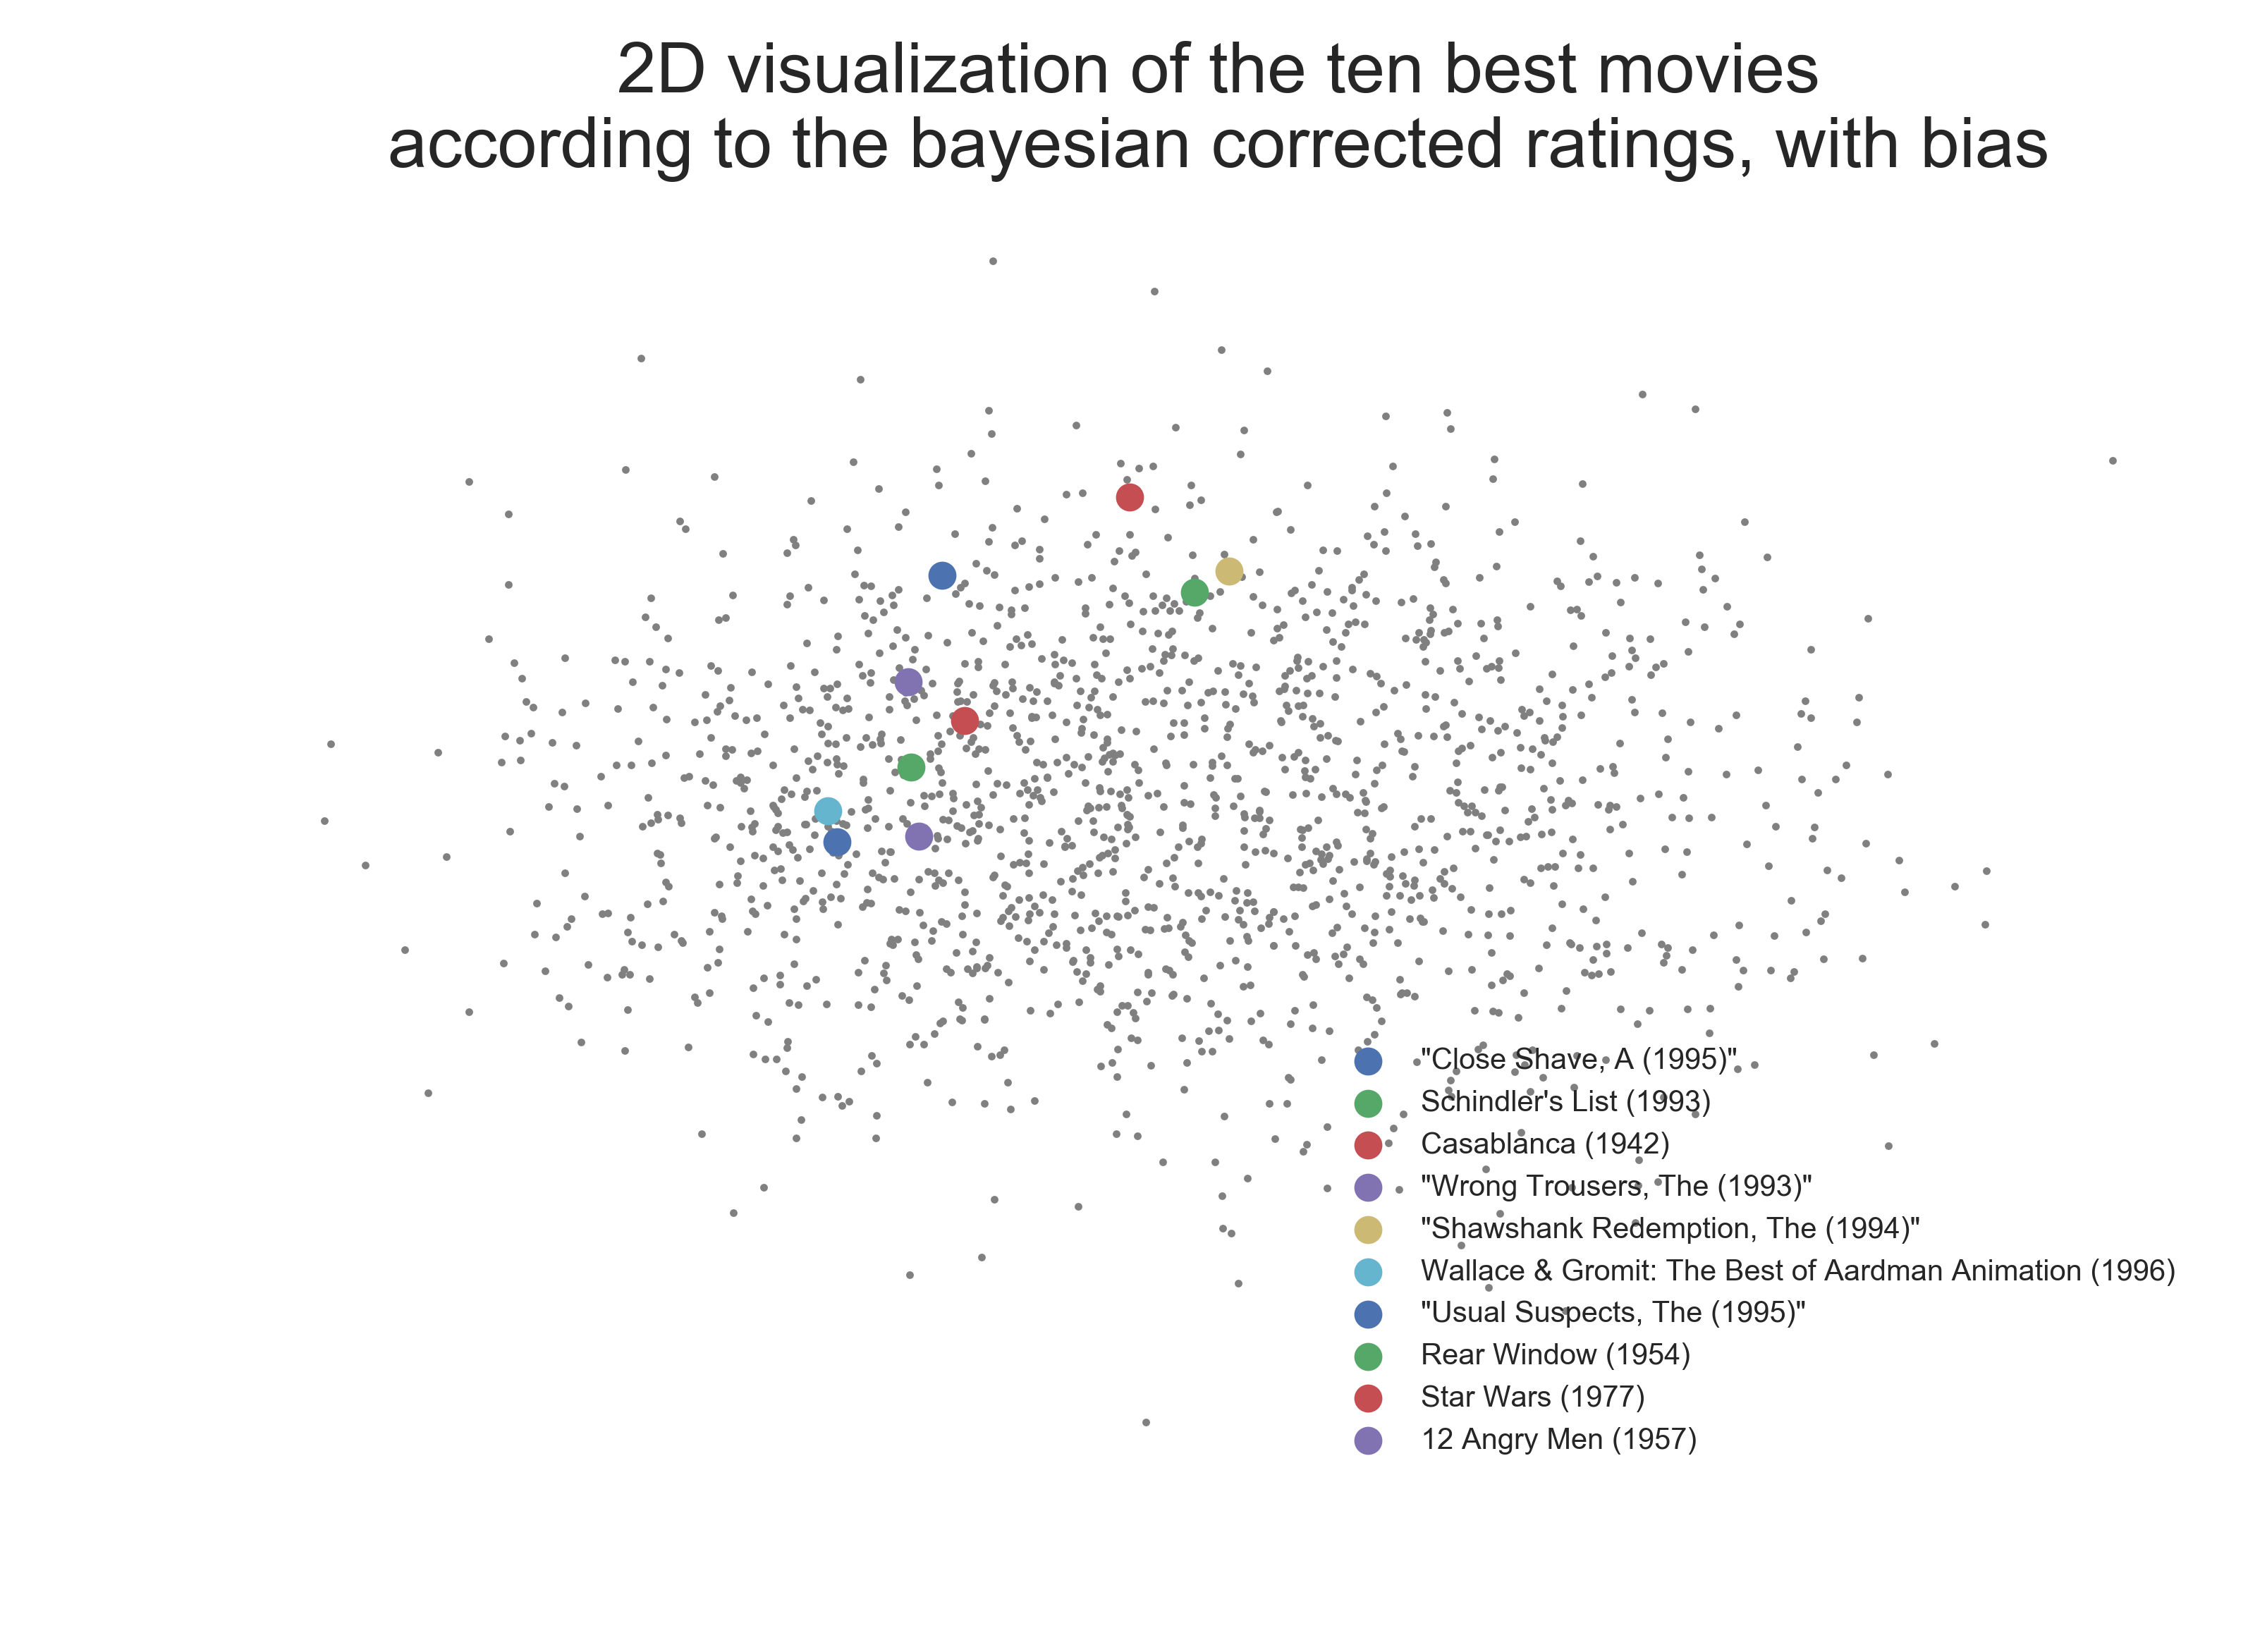

In [29]:
data = V2_bias
plt.figure(dpi=300)
plt.scatter(data[0, :], data[1, :], 1, 'gray')
for idx in rank_ratings_bayesian[:10]:
    plt.scatter(data[0, idx], data[1, idx], 20, label=movie_title[idx])
plt.axis('off')
plt.legend(prop={'size': 5})
plt.title('2D visualization of the ten best movies\naccording to the bayesian corrected ratings, with bias')
plt.show()

## Movies from 3 genres

In [21]:
def get_random_genre_projection_plot(genre, title):
    
    genre_movie_ids = movie_id[np.where(movie_genre[:, np.where(genres == genre)[0][0]] == 1)] - 1
    genre_movie_ids = np.random.choice(genre_movie_ids, 10)
    genre_movie_titles = movie_title[genre_movie_ids]

    plot = get_custom_movie_projection_plot(V_bias_transformed[:, genre_movie_ids], genre_movie_titles, "%s %s" % (title, genre), size=800)
    return plot

plot = get_random_genre_projection_plot("Childrens", "Biased SVD Projection")
show(plot)

In [22]:
plot = get_random_genre_projection_plot("War", "Biased SVD Projection")
show(plot)

In [23]:
plot = get_random_genre_projection_plot("Comedy", "Biased SVD Projection")
show(plot)